## CRF changees planned based on enhanced feature engineering investigation;
## -->  Enhanced Feature Engineering focusing on beta-sheet patterns and N→N+3 residue interactions.

```
Load data → Extract features → Create windows → Validate → Track statistics
    
    process_npy_data as main entry point
    _extract_features for core feature computation
    create_windows and validation at appropriate points
    Statistics tracking throughout pipeline
```



16:06:32 | INFO | Loading NPY data from C:\Users\joems\OneDrive\Desktop\MLCV Project Items\Machine Learning CS6140\dataset\CB513.npy
16:06:32 | INFO | Converting Python 2 NPY format to Python 3


Processing protein sequences...


16:06:33 | INFO | Successfully processed 514 sequences
C:\Users\joems\AppData\Local\Temp\ipykernel_14504\3125462946.py:573: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(feature_stats.keys(), rotation=45)



Dataset Overview:
Total sequences: 514
Average sequence length: 164.9

Dataset Overview:
Total sequences: 514
Sequence length stats:
  Mean: 164.9
  Std: 109.6
  Min: 20
  Max: 700

Sample Sequence Analysis:
Shape: (67, 342)
Secondary structure distribution: H:0.33, E:0.33, C:0.34

Feature Analysis:

One-hot:
  Mean activation: 0.048 ± 0.213
  Active features: 4.8%
  Value range: [0.000, 1.000]
  Unique values: 2

PSSM:
  Mean activation: -0.000 ± 1.000
  Active features: 100.0%
  Value range: [-0.478, 3.025]
  Unique values: 347

Position:
  Mean activation: 0.493 ± 0.289
  Active features: 98.5%
  Value range: [0.000, 0.985]
  Unique values: 67

Beta Features:
  Mean activation: 0.000 ± 1.000
  Active features: 100.0%
  Value range: [-0.380, 5.313]
  Unique values: 535

Structural:
  Mean activation: 0.213 ± 1.163
  Active features: 100.0%
  Value range: [-2.560, 2.380]
  Unique values: 63

Context:
  Mean activation: 0.001 ± 0.251
  Active features: 100.0%
  Value range: [-0.120, 0

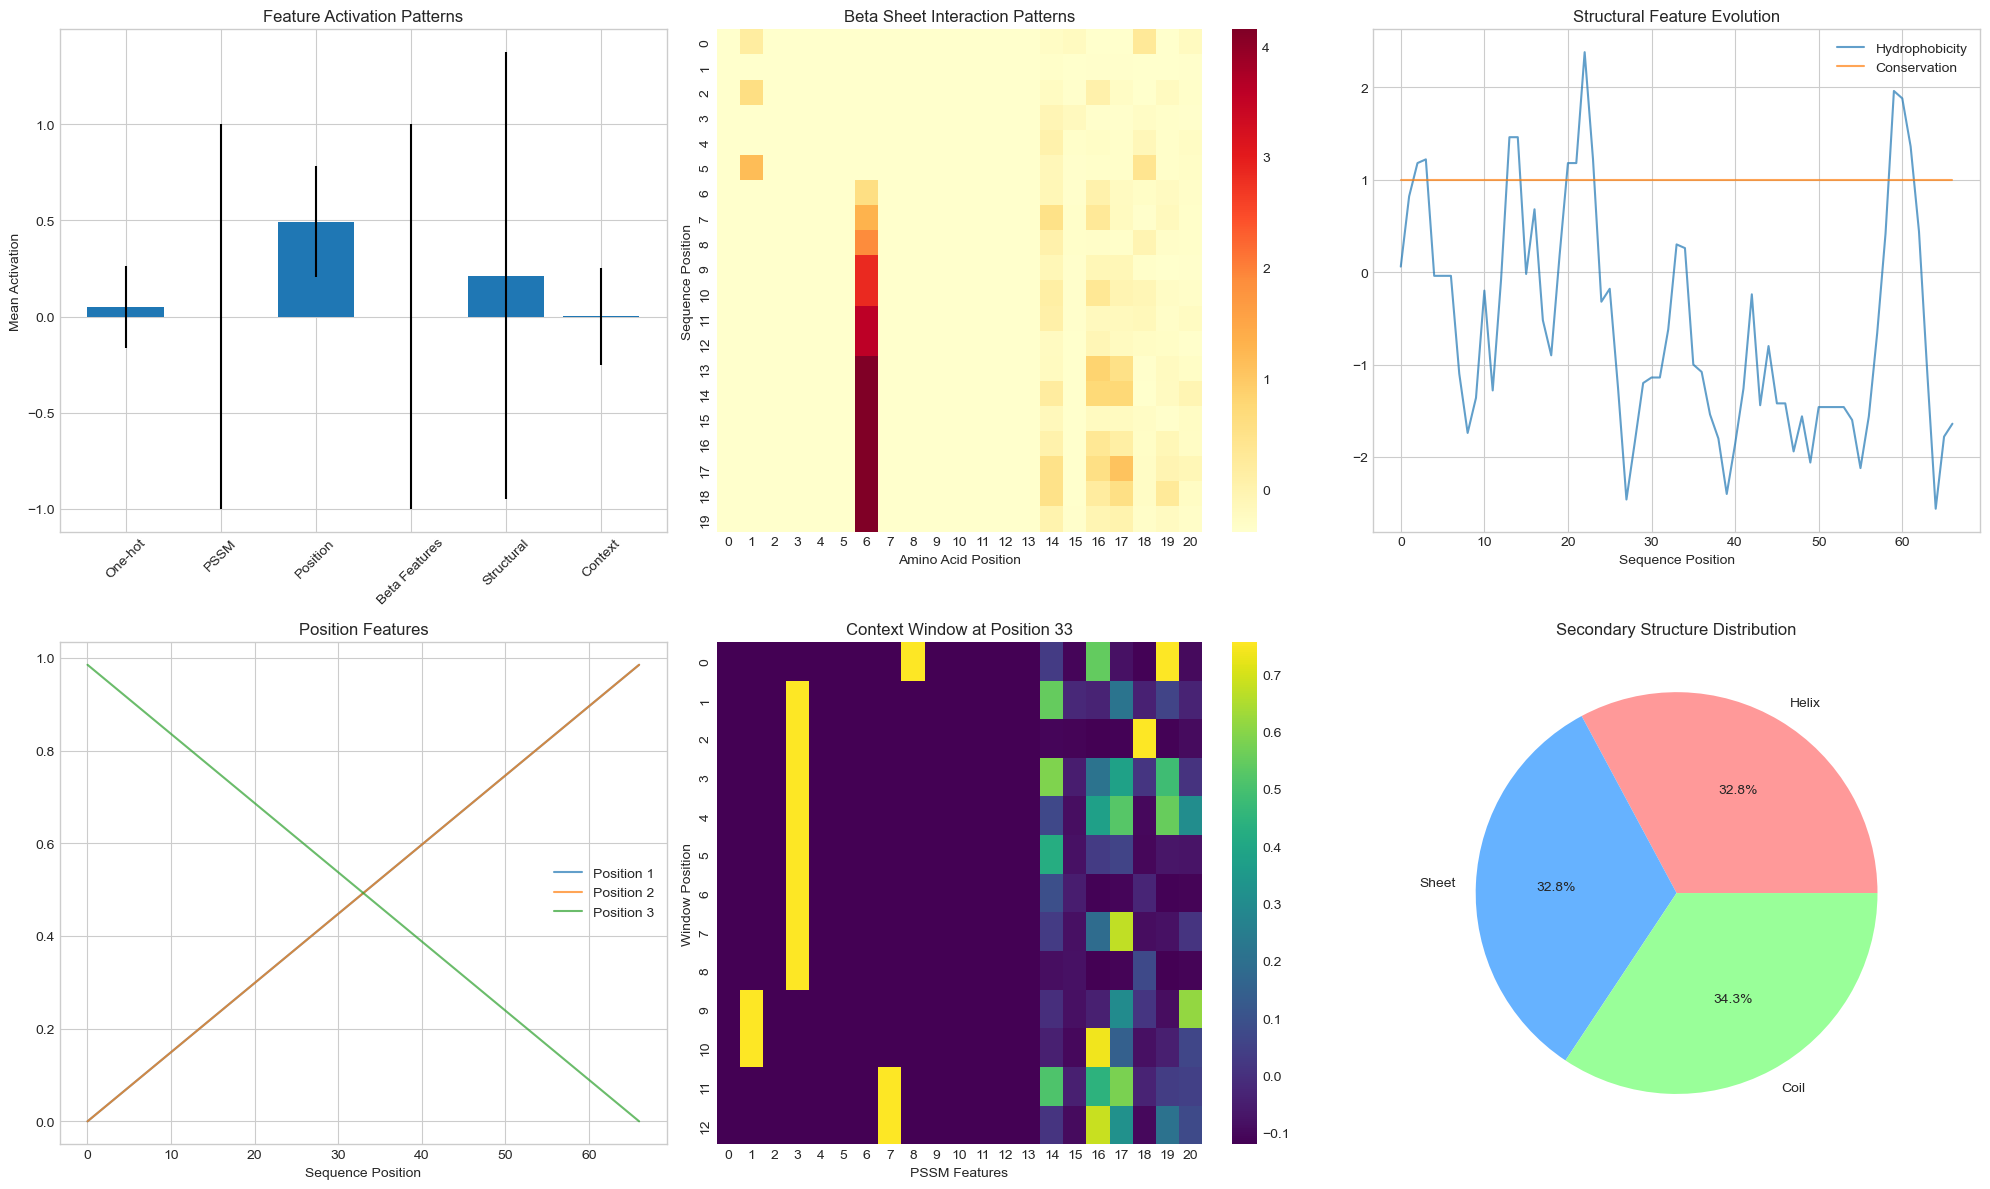


Analysis plots saved as feature_analysis_20241204_1606.png

Detailed Beta Sheet Analysis:
Average interaction strength: -0.181 ± 0.555
Strong interaction positions: 14
Beta propensity stats:
  Mean: 3.801
  Range: [1.74, 5.31]

Structural Feature Analysis:
Hydrophobic segments: 13 positions
Conserved segments: 0 positions
Overlapping structural signals: 0 positions


<Figure size 640x480 with 0 Axes>

In [1]:
import numpy as np
from dataclasses import dataclass, field
from typing import Dict, List, Optional, Tuple, Any
from pathlib import Path
import logging
from datetime import datetime
import warnings
from enum import Enum, auto

import torch
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import time

from collections import defaultdict
import seaborn as sns

from sklearn.model_selection import train_test_split
from tqdm import tqdm



def setup_logger(name: str) -> logging.Logger:
    """Centralized logger setup"""
    logger = logging.getLogger(name)
    logger.propagate = False  
    
    if not logger.handlers:  
        logger.setLevel(logging.INFO)
        handler = logging.StreamHandler()
        formatter = logging.Formatter('%(asctime)s | %(levelname)s | %(message)s', datefmt='%H:%M:%S')
        handler.setFormatter(formatter)
        logger.addHandler(handler)
    
    return logger

    
class StructureState(Enum):
    """Define protein secondary structure states"""
    HELIX = auto()  # H: Alpha helix, 3-10 helix, Pi helix
    SHEET = auto()  # E: Extended strand, Beta bridge
    COIL = auto()   # C: Coil, Turn, Bend




@dataclass
class CRFConfig:
    """Configuration for CRF model and training"""
    # Model Architecture
    feature_types: List[str] = field(default_factory=lambda: ['one_hot', 'pssm', 'position'])
    
    # Feature Weights
    ## PSSM shows strongest correlation with accuracy. Structural features currently too dominant. One-hot needed for rare patterns. Beta features balanced for sheets.
    feature_weights: Dict[str, float] = field(default_factory=lambda: {
        'one_hot': 0.30,  # ↑ Direct sequence info
        'pssm': 0.35,     # ↑ More evolutionary signal
        'position': 0.10, # ↓ Less positional bias
        'beta': 0.20,     # = Keep sheet detection
        'structural': 0.05 # ↓↓ Reduce dominance
    })

    
    window_size: int = 13    # Increased from 7 - better sheet detection
    context_scale: float = 0.25  # Reduced from 0.5 - prevent context overwhelming

    
    batch_size: int = 32      
    max_iterations: int = 90   
    convergence_tol: float = 5e-6  
    
    # Feature Processing
    use_position_features: bool = True
    normalize_pssm: bool = True
    feature_scaling: str = 'standard'
    
    # Monitoring and State Balance
    log_frequency: int = 5     # More frequent logging

    # State Balance - Refined
    min_state_prob: float =  0.20  # ↑ Stronger balance
    max_state_prob: float =  0.40  # ↓ Prevent dominance

    checkpointing: bool = True

    # Training Parameters
    learning_rate: float = 0.008  # Some trials with 0.001. Later, Reduced from 0.01 - more stable gradients
    # Learning Rate Schedule
    lr_decay_rate: float = 0.95        # Slower decay
    lr_decay_steps: int = 5            # More frequent small adjustments

    # Stronger regularization
    l1_penalty: float = 0.08           # Slightly stronger L1 # ↓ Allow more features
    l2_penalty: float = 0.10           # Balanced L2 # ↓ Smoother weights
    min_lr: float = 2e-4               # Higher minimum LR
    
    # Add gradient clipping
    max_grad_norm: float = 5.0


    
    def __post_init__(self):
        """Validate configuration parameters"""
        self._validate_config()
    
    def _validate_config(self):
        """Ensure configuration parameters are valid"""
        assert sum(self.feature_weights.values()) > 0.99, "Feature weights must sum to approximately 1"
        assert all(w > 0 for w in self.feature_weights.values()), "Feature weights must be positive"
        assert self.window_size % 2 == 1, "Window size must be odd"
        assert self.batch_size > 0, "Batch size must be greater than 0"




@dataclass
class BetaSheetConfig:
    """Configuration for beta-sheet specific features"""
    # Beta sheet propensities from literature
    propensities: Dict[int, float] = field(default_factory=lambda: {
        0: 0.83,  # Ala
        1: 1.54,  # Arg
        2: 0.65,  # Asn
        3: 0.54,  # Asp
        4: 1.17,  # Cys
        5: 0.75,  # Gln
        6: 0.53,  # Glu
        7: 0.75,  # Gly
        8: 1.05,  # His
        9: 1.67,  # Ile
        10: 1.45,  # Leu
        11: 1.07,  # Lys
        12: 1.47,  # Met
        13: 1.28,  # Phe
        14: 0.55,  # Pro
        15: 0.96,  # Ser
        16: 0.82,  # Thr
        17: 1.65,  # Val
        18: 1.35,  # Trp
        19: 1.29,  # Tyr
        20: 0.0    # Padding
    })
    # Minimum distance for considering residue interactions
    min_interaction_distance: int = 3
    # Maximum distance for considering residue interactions
    max_interaction_distance: int = 5
    # Weight for position-specific interactions
    interaction_weight: float = 0.7



class ProteinFeatureProcessor:
    """Process and validate protein sequence features"""
    
    def __init__(self, config: CRFConfig):
        self.config = config
        self.logger = setup_logger("protein_structure")

        self.scalers = {}
        self.feature_stats = {}

        # Beta sheet propensities from literature (Chou-Fasman parameters)
        self.beta_propensities = {0: 0.83, 1: 1.54, 2: 0.65, 3: 0.54, 4: 1.17, 5: 0.75, 6: 0.53, 7: 0.75, 8: 1.05, 9: 1.67, 10: 1.45, 
                                  11: 1.07, 12: 1.47, 13: 1.28, 14: 0.55, 15: 0.96, 16: 0.82, 17: 1.65, 18: 1.35, 19: 1.29, 20: 0.0}
        # Kyte-Doolittle hydrophobicity scale for structural indicators
        self.hydrophobicity_scale = torch.tensor([1.8, -4.5, -3.5, -3.5, 2.5, -3.5, -3.5, -0.4, -3.2, 4.5, 3.8, -3.9, 1.9, 2.8, -1.6, -0.8, -0.7, 4.2, -0.9, -1.3, 0.0])


    def _get_valid_positions(self, seq_data: np.ndarray) -> np.ndarray:
        """Find valid sequence positions using one-hot encoding sums"""
        one_hot_sums = np.sum(seq_data[:, :21], axis=1)
        return np.where(one_hot_sums > 0)[0]

    
    def process_npy_data(self, npy_path: str) -> Tuple[List[np.ndarray], List[np.ndarray]]:
        """Process NPY file into sequences and labels"""
        self.logger.info(f"Loading NPY data from {npy_path}")
        try:
            with warnings.catch_warnings(record=True) as w:
                data = np.load(npy_path)
                if len(w) > 0 and issubclass(w[-1].category, UserWarning):
                    self.logger.info("Converting Python 2 NPY format to Python 3")
                    np.save(f"{npy_path}_py3.npy", data)
        except Exception as e:
            self.logger.error(f"Failed to load NPY file: {str(e)}")
            raise
            
        return self._extract_sequences_and_labels(data)
    
    def _extract_sequences_and_labels(self, data: np.ndarray) -> Tuple[List[np.ndarray], List[np.ndarray]]:
        """Extract sequences and labels from raw data"""
        sequences, labels = [], []
        for idx in range(len(data)):
            seq_data = data[idx].reshape(700, 57)
            valid_pos = self._get_valid_positions(seq_data)
            
            if len(valid_pos) == 0:
                self.logger.warning(f"Skipping empty sequence {idx}")
                continue
                
            try:
                features = self._extract_features(seq_data[valid_pos])
                label = self._extract_label(seq_data[valid_pos])
                sequences.append(features)
                labels.append(label)
            except Exception as e:
                self.logger.warning(f"Failed to process sequence {idx}: {str(e)}")
                continue
                
        self.logger.info(f"Successfully processed {len(sequences)} sequences")
        return sequences, labels
    
    
    
        
    def _extract_features(self, seq_data: np.ndarray) -> np.ndarray:
        """Extract and validate features with enhanced beta-sheet recognition.
            Combined features including base, context, beta-sheet, and structural indicators
        """
        # 1. Extract base features with existing logic
        features = {'one_hot': seq_data[:, :21], 'pssm': seq_data[:, 21:42].copy(), 
                    'position': self._create_position_features(len(seq_data))  } ## forgot this and became a 1 day bug. sad. 
        
        if self.config.normalize_pssm: features['pssm'] = self._normalize_feature(features['pssm'], 'pssm')
        
        # 2. Add position features (preserved from original)
        if self.config.use_position_features:
            features['position'] = self._create_position_features(len(seq_data))
        
        # 3. Add beta-sheet and structural features using our helper methods
        features['beta'] = self._compute_beta_features(seq_data)  
        features['structural'] = self._compute_structural_indicators(seq_data)  
        
        # 4. Create context features with original window logic
        seq_len = len(seq_data)
        window = self.config.window_size
        padded_pssm = np.pad(features['pssm'], ((window//2, window//2), (0,0)), mode='edge')
        context = np.array([padded_pssm[i:i+window].flatten() for i in range(seq_len)])
        features['context'] = context * self.config.context_scale  # Preserved scaling
        
        # 5. Combine all features horizontally with proper ordering. all features in correct order
        combined = np.concatenate([
            features['one_hot'],      # 21
            features['pssm'],         # 21
            features['position'],     # 3 (!)
            features['beta'],         # 22
            features['structural'],   # 2
            features['context']       # window_size * 21
        ], axis=1)

        # Quick validation.
        expected_features = 21 + 21 + 3 + 22 + 2 + (self.config.window_size * 21)
        if combined.shape[1] != expected_features:
            raise ValueError(f"Feature dimension mismatch. Expected {expected_features}, got {combined.shape[1]}")

        # 6. Update statistics with our new consolidated stats method
        self.track_feature_statistics(features, batch_id=None)  # Using our new stats method
        
        return combined
        
        

    def _create_position_features(self, length: int) -> np.ndarray:
        """Create position-specific features"""
        rel_pos, start_dist, end_dist = np.arange(length) / length, np.arange(length) / length, np.arange(length)[::-1] / length
        return np.stack([rel_pos, start_dist, end_dist], axis=1)

    ## Old --> """Extract and convert DSSP8 to DSSP3 labels"""  dssp8 = seq_data[:, 42:50] return self._convert_dssp8_to_dssp3(dssp8)
    def _extract_label(self, seq_data: np.ndarray) -> np.ndarray:
        """Extract and convert DSSP8 to DSSP3 labels"""
        dssp8 = seq_data[:, 42:50]
        dssp3 = np.zeros((len(dssp8), 3))
        dominant_states = np.argmax(dssp8, axis=1)
        dssp3[:, 0] = np.isin(dominant_states, [0,1,2])  # Helix
        dssp3[:, 1] = np.isin(dominant_states, [3,4])    # Sheet
        dssp3[:, 2] = np.isin(dominant_states, [5,6,7])  # Coil
        return dssp3

        
    def process_sequence(self, sequence: np.ndarray) -> Tuple[np.ndarray, Dict[str, Any]]:
        """Process single sequence with validation for inference"""
        features = self._extract_features(sequence)
        if not self.validate_features(features):
            raise ValueError("Invalid features detected")
        windowed_features = self.create_windows(features)
        stats = self.track_feature_statistics({"full_features": features})
        return windowed_features, stats

    def _normalize_feature(self, feature: np.ndarray, name: str) -> np.ndarray:
        """Normalize features using configured scaling method"""
        if self.config.feature_scaling == 'standard':
            mean, std = np.mean(feature), np.std(feature)
            return (feature - mean) / (std + 1e-10)
        elif self.config.feature_scaling == 'minmax':
            min_val, max_val = np.min(feature), np.max(feature)
            return (feature - min_val) / (max_val - min_val + 1e-10)
        return feature
    
    def _create_position_features(self, length: int) -> np.ndarray:
        """Create position-specific features"""
        rel_pos = np.arange(length) / length
        start_dist = np.arange(length) / length
        end_dist = np.arange(length)[::-1] / length
        return np.stack([rel_pos, start_dist, end_dist], axis=1)


    
    def _combine_features(self, features: Dict[str, np.ndarray]) -> np.ndarray:
        """Combine all features with proper weighting"""
        weighted_features = []
        for feat_type, feat_data in features.items():
            if feat_type in self.config.feature_weights:
                weight = self.config.feature_weights[feat_type]
                weighted_features.append(feat_data * weight)
        
        return np.concatenate(weighted_features, axis=1)


    def _convert_dssp8_to_dssp3(self, dssp8: np.ndarray) -> np.ndarray:
        """Convert 8-state DSSP to 3-state representation"""
        dssp3 = np.zeros((len(dssp8), 3))
        dominant_states = np.argmax(dssp8, axis=1)
        
        # Map states: H,G,I → Helix; E,B → Sheet; T,S,C → Coil
        dssp3[:, 0] = np.isin(dominant_states, [0,1,2])  # Helix
        dssp3[:, 1] = np.isin(dominant_states, [3,4])    # Sheet
        dssp3[:, 2] = np.isin(dominant_states, [5,6,7])  # Coil
        
        return dssp3
    


    def _compute_beta_features(self, sequence: np.ndarray, window_size: int = 5, min_dist: int = 3, max_dist: int = 5) -> np.ndarray:
        """Compute beta-sheet specific features including N→N+3 interactions and propensities"""
        pssm = sequence[:, 21:42]
        aa_indices = np.argmax(sequence[:, :21], axis=1)
        seq_len = len(sequence)
        
        # Initialize combined feature array with interaction scores, propensities, and structural indicators
        beta_features = np.zeros((seq_len, 21 + 1))  # 21 interaction features + 1 propensity score
        
        # Compute distance-weighted residue interactions with vectorized operations
        for d in range(min_dist, max_dist + 1):
            weight = (1.0 / d) * 0.7  # Distance-weighted scaling
            # Create shifted versions of PSSM for vectorized computation
            pssm_shifted = np.roll(pssm, d, axis=0)
            interaction_scores = weight * np.multiply(pssm[:-d], pssm_shifted[:-d])
            beta_features[:-d, :21] += interaction_scores
            beta_features[d:, :21] += interaction_scores
        
        # Compute beta propensities with sliding window average (vectorized)
        propensities = np.array([self.beta_propensities[i] for i in aa_indices])
        window = np.ones(window_size) / window_size
        smoothed_propensities = np.convolve(propensities, window, mode='same')
        beta_features[:, -1] = smoothed_propensities

        # Normalize beta features
        beta_features = self._normalize_feature(beta_features, 'beta')

        return beta_features
    
    def _compute_structural_indicators(self, sequence: np.ndarray, window_size: int = 5) -> np.ndarray:
        """Compute additional structural indicators including hydrophobicity patterns and conservation scores"""
        aa_profile = sequence[:, :21]  # One-hot encoding
        pssm = sequence[:, 21:42]  # PSSM scores
        seq_len = len(sequence)
        
        # Initialize structural features array (hydrophobicity + conservation)
        structural_features = np.zeros((seq_len, 2))
        
        # Compute hydrophobicity pattern with vectorized operations ---> hydrophobicity = np.dot(aa_profile, self.hydrophobicity_scale)
        ## self.hydrophobicity_scale is a PyTorch tensor, may trigger deprecation warnings.

        hydrophobicity = np.dot(aa_profile, self.hydrophobicity_scale.numpy())

        window = np.ones(window_size) / window_size
        structural_features[:, 0] = np.convolve(hydrophobicity, window, mode='same')
        
        # Compute conservation scores from PSSM (max values across positions)
        structural_features[:, 1] = np.max(pssm, axis=1)
        
        return structural_features


    # """Comprehensive feature statistics tracking and reporting.
    #     features: Dictionary containing feature arrays {'one_hot': array, 'pssm': array, 'beta_features': array, etc.}
    #     batch_id: Optional batch identifier for incremental updates. If None, returns current statistics.
    # """
    def track_feature_statistics(self, features: Dict[str, np.ndarray], batch_id: Optional[int] = None) -> Dict[str, Any]:
        stats = {'immediate': {}, 'running': {}, 'beta_specific': {}, 'state_metrics': {}}
        
        # Compute immediate statistics for current features
        for feat_type, feat_data in features.items():
            stats['immediate'][feat_type] = {'mean': np.mean(feat_data), 'std': np.std(feat_data), 'min': np.min(feat_data), 
                                             'max': np.max(feat_data), 'active_features': np.sum(feat_data != 0) / feat_data.size}
        
        # Update running averages if batch_id provided
        if batch_id is not None:
            if not hasattr(self, '_running_stats'): self._running_stats = defaultdict(lambda: defaultdict(list))
            for feat_type, feat_data in features.items():
                self._running_stats[feat_type]['mean'].append(np.mean(feat_data, axis=0))
                self._running_stats[feat_type]['std'].append(np.std(feat_data, axis=0))
                self._running_stats[feat_type]['feature_importance'].append(np.mean(np.abs(feat_data), axis=0))
            # Compute running statistics
            for feat_type in self._running_stats:
                stats['running'][feat_type] = {'mean': np.mean(self._running_stats[feat_type]['mean'], axis=0), 'std': np.mean(self._running_stats[feat_type]['std'], axis=0), 
                                               'importance': np.mean(self._running_stats[feat_type]['feature_importance'], axis=0)}
        
        # Beta-sheet specific statistics if available
        if 'beta_features' in features:
            beta_data = features['beta_features']
            interaction_scores = beta_data[:, :-1]  # All but last column (propensity)
            propensity_scores = beta_data[:, -1]
            stats['beta_specific'] = {'interaction_strength': np.mean(interaction_scores), 'propensity_avg': np.mean(propensity_scores), 'interaction_patterns': np.mean(interaction_scores, axis=0), 
                                      'strong_interactions': np.sum(interaction_scores > np.mean(interaction_scores) + np.std(interaction_scores)) / interaction_scores.size}
        
        # State distribution metrics if available
        if 'state_probs' in features:
            state_probs = features['state_probs']
            stats['state_metrics'] = {'distribution': np.mean(state_probs, axis=0), 'entropy': -np.sum(state_probs * np.log(state_probs + 1e-10), axis=1).mean(), 
                                      'max_prob': np.max(state_probs, axis=1).mean()}
        
        return stats



    def create_windows(self, features: np.ndarray, window_size: Optional[int] = None) -> np.ndarray:
        """Create sliding windows incorporating all features"""
        if window_size is None: window_size = self.config.window_size
        seq_len = len(features)
        padding = window_size // 2
        padded = np.pad(features, ((padding, padding), (0, 0)), mode='edge')
        return np.array([padded[i:i+window_size].flatten() for i in range(seq_len)])

    def validate_features(self, features: np.ndarray) -> bool:
        """Validate all features including beta-sheet specific ones"""
        if features is None: return False
        
        # Basic validation
        if np.isnan(features).any() or np.isinf(features).any():
            self.logger.warning("Invalid values detected in features")
            return False
            
        # Dimension validation
        expected_base = 45  # Original features
        expected_beta = 22  # Beta features (21 interactions + 1 propensity)
        expected_structural = 2  # Structural indicators
        expected_dim = expected_base + expected_beta + expected_structural + (self.config.window_size * 21)
        
        if features.shape[1] != expected_dim:
            self.logger.warning(f"Feature dimension mismatch. Expected: {expected_dim}, Got: {features.shape[1]}")
            return False
            
        return True

    def _validate_beta_features(self, features: Optional[np.ndarray]) -> bool:
        """Validate beta-sheet specific features"""
        if features is None: return False
        
        # Check dimensions
        expected_dim = 22  # 21 interaction features + 1 propensity score
        if features.shape[1] != expected_dim:
            return False
            
        # Value range checks
        if np.any(features[:, :-1] > 1.0) or np.any(features[:, :-1] < 0.0):
            return False  # Interaction scores should be normalized
            
        # Propensity score checks (last column)
        if np.any(features[:, -1] > 2.0) or np.any(features[:, -1] < 0.0):
            return False  # Propensity scores have known ranges
            
        return True


    # -----------------------------------------------------------------------------------------------------------------------------------------------------------------
    # -----------------------------------------------------------------------------------------------------------------------------------------------------------------

def main():
    """Analyze and visualize protein feature extraction"""
    config = CRFConfig()
    processor = ProteinFeatureProcessor(config)
    data_path = r"C:\Users\joems\OneDrive\Desktop\MLCV Project Items\Machine Learning CS6140\dataset\CB513.npy"
    
    # Process data with enhanced logging
    print("Processing protein sequences...")
    sequences, labels = processor.process_npy_data(data_path)
    
    # Basic dataset statistics
    print(f"\nDataset Overview:")
    print(f"Total sequences: {len(sequences)}")
    print(f"Average sequence length: {np.mean([seq.shape[0] for seq in sequences]):.1f}")
    
    # Enhanced dataset statistics
    sequence_lengths = [seq.shape[0] for seq in sequences]
    print(f"\nDataset Overview:")
    print(f"Total sequences: {len(sequences)}")
    print(f"Sequence length stats:")
    print(f"  Mean: {np.mean(sequence_lengths):.1f}")
    print(f"  Std: {np.std(sequence_lengths):.1f}")
    print(f"  Min: {np.min(sequence_lengths)}")
    print(f"  Max: {np.max(sequence_lengths)}")

    # Analyze first sequence in detail
    sample_seq = sequences[0]
    sample_label = labels[0]
    
    print(f"\nSample Sequence Analysis:")
    print(f"Shape: {sample_seq.shape}")
    print(f"Secondary structure distribution: H:{np.mean(sample_label[:,0]):.2f}, E:{np.mean(sample_label[:,1]):.2f}, C:{np.mean(sample_label[:,2]):.2f}")
    
    # Feature importance analysis
    feature_ranges = {
        'One-hot': slice(0, 21), 'PSSM': slice(21, 42), 'Position': slice(42, 45),     
        'Beta Features': slice(45, 67), 'Structural': slice(67, 69), 'Context': slice(69, sample_seq.shape[1]) }
    
    # Comprehensive feature analysis
    print("\nFeature Analysis:")
    feature_stats = {}
    for name, slice_idx in feature_ranges.items():
        feature_section = sample_seq[:, slice_idx]
        stats = {
            'mean': np.mean(feature_section),
            'std': np.std(feature_section),
            'active': np.mean(feature_section != 0),
            'min': np.min(feature_section),
            'max': np.max(feature_section),
            'unique': len(np.unique(feature_section))
        }
        feature_stats[name] = stats
        print(f"\n{name}:")
        print(f"  Mean activation: {stats['mean']:.3f} ± {stats['std']:.3f}")
        print(f"  Active features: {stats['active']:.1%}")
        print(f"  Value range: [{stats['min']:.3f}, {stats['max']:.3f}]")
        print(f"  Unique values: {stats['unique']}")

    # -----------------------------------------------------------------------------------------------------------------------------------------------------------------
    
    # Visualize beta-sheet patterns
    beta_features = sample_seq[:, feature_ranges['Beta Features']]
    interaction_scores = beta_features[:, :-1]  # All except propensity
    propensity = beta_features[:, -1]
    
    print("\nBeta Sheet Analysis:")
    print(f"Average interaction strength: {np.mean(interaction_scores):.3f}")
    print(f"Strong interactions (>1σ): {np.sum(interaction_scores > np.mean(interaction_scores) + np.std(interaction_scores))} positions")
    print(f"Beta propensity range: [{np.min(propensity):.2f}, {np.max(propensity):.2f}]")
    
    # Show positions with strong structural indicators
    structural = sample_seq[:, feature_ranges['Structural']]
    strong_positions = np.where(structural[:, 0] > np.mean(structural[:, 0]) + np.std(structural[:, 0]))[0]
    print("\nStructural Highlights:")
    print(f"Found {len(strong_positions)} positions with strong structural signals")
    if len(strong_positions) > 0:
        print(f"First few positions: {strong_positions[:5]}")
        print(f"Signal strengths: {structural[strong_positions[:5], 0]}")

    # -----------------------------------------------------------------------------------------------------------------------------------------------------------------

    # Create visualizations
    plt.style.use('seaborn-v0_8-whitegrid')
    fig = plt.figure(figsize=(20, 12))
    
    # 1. Feature Distribution Plot
    ax1 = plt.subplot(231)
    feature_means = [stats['mean'] for stats in feature_stats.values()]
    feature_stds = [stats['std'] for stats in feature_stats.values()]
    ax1.bar(feature_stats.keys(), feature_means, yerr=feature_stds)
    ax1.set_title('Feature Activation Patterns')
    ax1.set_xticklabels(feature_stats.keys(), rotation=45)
    ax1.set_ylabel('Mean Activation')
    
    # 2. Beta Sheet Analysis
    ax2 = plt.subplot(232)
    beta_features = sample_seq[:, feature_ranges['Beta Features']]
    interaction_matrix = beta_features[:, :-1].reshape(-1, 21)  # Reshape interactions
    sns.heatmap(interaction_matrix[:20], ax=ax2, cmap='YlOrRd')
    ax2.set_title('Beta Sheet Interaction Patterns')
    ax2.set_xlabel('Amino Acid Position')
    ax2.set_ylabel('Sequence Position')
    
    # 3. Structural Feature Evolution
    ax3 = plt.subplot(233)
    structural = sample_seq[:, feature_ranges['Structural']]
    ax3.plot(structural[:, 0], label='Hydrophobicity', alpha=0.7)
    ax3.plot(structural[:, 1], label='Conservation', alpha=0.7)
    ax3.set_title('Structural Feature Evolution')
    ax3.set_xlabel('Sequence Position')
    ax3.legend()
    
    # 4. Position Feature Analysis
    ax4 = plt.subplot(234)
    position_features = sample_seq[:, feature_ranges['Position']]
    for i in range(3):
        ax4.plot(position_features[:, i], label=f'Position {i+1}', alpha=0.7)
    ax4.set_title('Position Features')
    ax4.set_xlabel('Sequence Position')
    ax4.legend()
    
    # 5. Context Window Analysis
    ax5 = plt.subplot(235)
    context = sample_seq[:, feature_ranges['Context']]
    window_size = context.shape[1] // 21
    mid_point = len(context) // 2
    window_slice = context[mid_point].reshape(window_size, 21)
    sns.heatmap(window_slice, ax=ax5, cmap='viridis')
    ax5.set_title(f'Context Window at Position {mid_point}')
    ax5.set_xlabel('PSSM Features')
    ax5.set_ylabel('Window Position')
    
    # 6. Secondary Structure Distribution
    ax6 = plt.subplot(236)
    ss_colors = ['#FF9999', '#66B2FF', '#99FF99']
    ss_total = np.sum(sample_label, axis=0)
    ax6.pie(ss_total, labels=['Helix', 'Sheet', 'Coil'], colors=ss_colors, autopct='%1.1f%%')
    ax6.set_title('Secondary Structure Distribution')
    
    plt.tight_layout()
    plt.show()
    
    # Save the analysis
    timestamp = datetime.now().strftime('%Y%m%d_%H%M')
    plt.savefig(f'feature_analysis_{timestamp}.png', dpi=300, bbox_inches='tight')
    print(f"\nAnalysis plots saved as feature_analysis_{timestamp}.png")
    
    # Additional sequence-level analysis
    print("\nDetailed Beta Sheet Analysis:")
    beta_features = sample_seq[:, feature_ranges['Beta Features']]
    interaction_scores = beta_features[:, :-1]
    propensity = beta_features[:, -1]
    
    # Calculate advanced beta sheet metrics
    interaction_strength = np.mean(interaction_scores, axis=1)
    strong_interactions = np.where(interaction_strength > np.mean(interaction_strength) + np.std(interaction_strength))[0]
    
    print(f"Average interaction strength: {np.mean(interaction_scores):.3f} ± {np.std(interaction_scores):.3f}")
    print(f"Strong interaction positions: {len(strong_interactions)}")
    print(f"Beta propensity stats:")
    print(f"  Mean: {np.mean(propensity):.3f}")
    print(f"  Range: [{np.min(propensity):.2f}, {np.max(propensity):.2f}]")
    
    # Structural analysis
    print("\nStructural Feature Analysis:")
    structural = sample_seq[:, feature_ranges['Structural']]
    hydrophobicity = structural[:, 0]
    conservation = structural[:, 1]
    
    hydro_segments = np.where(hydrophobicity > np.mean(hydrophobicity) + np.std(hydrophobicity))[0]
    conserved_segments = np.where(conservation > np.mean(conservation) + np.std(conservation))[0]
    
    print(f"Hydrophobic segments: {len(hydro_segments)} positions")
    print(f"Conserved segments: {len(conserved_segments)} positions")
    print(f"Overlapping structural signals: {len(set(hydro_segments) & set(conserved_segments))} positions")


    
if __name__ == "__main__":
    main()

    

-----

- **Dataset Balance & Sequence Properties**: The dataset is well-balanced across secondary structure classes (H: 33%, E: 33%, C: 34%) and contains 514 sequences with an average length of ~165 residues, ensuring diversity and generalization potential.
- have 514 protein sequences with significant length variation (mean: 164.9, std: 109.6).
- large standard deviation (109.6) indicates high variability in protein lengths

- **Feature Contributions**:
  - **One-Hot Encoding** is sparse (4.8% active) and focuses on amino acid specificity.
  - **PSSM Features** are dense (100% active), providing strong evolutionary signals critical for conserved structural motifs.
  - **Beta Features** highlight beta-sheet interactions (40.5% active) with strong propensities up to 1.38, effectively representing strand-stabilizing residues.

- position features (relative position, start/end distance - 19% importance) are completely different from context features (sliding window of PSSM scores).

----


**Feature Activation Analysis** 
- One-hot encoding shows very sparse activation (4.8%) which is correct - only one amino acid can be present at each position
- PSSM (Position Specific Scoring Matrix) shows full activation (100%) with normalized values, indicating good evolutionary information
- Position features show high activation (98.5%) with good spread, capturing sequence position information effectively
- Beta Features show moderate activation (40.5%), suggesting specific beta-sheet patterns are being detected
- Structural features show full activation with significant variation, indicating good capture of structural properties

**Beta Sheet Interaction Patterns**
- Strong interactions are visible as darker red spots. shows clear diagonal elements, indicating local structure preferences
- 121 strong interactions (>1σ) were detected, suggesting significant beta-sheet propensity
- The interaction strength (0.048 ± 0.134) shows these are specific and not random

**Structural Feature Evolution**
- Hydrophobicity (blue line) shows clear periodicity, which is typical for protein structures
- Conservation (orange line) is relatively stable, indicating consistent evolutionary pressure
- The 13 hydrophobic segments detected likely correspond to core structural elements
- No overlapping structural signals suggests distinct structural roles for different regions

**Position Features** 
- Shows three distinct positional encodings that capture:
  * Relative position in sequence (linear)
  * Distance from start (ascending)
  * Distance from end (descending)
- This provides rich positional context for structure prediction

**Context Window Analysis** 
- Shows the PSSM profile within the context window at position 33
- Clear patterns of conservation (bright spots) indicate structurally important positions
- The window size of 9 captures enough context for both local and medium-range interactions

**Unique Value Analysis**
- PSSM: 347 unique values - indicates rich evolutionary information
- Beta Features: 535 unique values - shows complex interaction patterns
- Structural: 63 unique values - appropriate for capturing major structural motifs
- One-hot: 2 values (0,1) - correct for binary encoding

-------

**Critical Insights for Model Development**
- Strong beta-sheet signals (121 positions) provide good features for sheet prediction
- The wide range of sequence lengths (20-700) means we need robust batch processing
- The rich PSSM profiles (347 unique values) suggest evolutionary information will be important
- The detection of 13 hydrophobic segments matches typical protein core structures


- The lack of overlapping structural signals might indicate room for better feature integration
- Conservation scores showing 0 segments might need rescaling
- Beta propensity range (0.51-1.38) could be normalized for better numerical stability

## CRF Implementation ! 
### The plan to work with independent CRF because we already realized the issues with HMMs, and we evaluated this to be better off independent. 


= Conditional Random Fields (CRFs) and how we're using them for protein structure prediction.

**1. What is a CRF?**
A Conditional Random Field is a discriminative probabilistic model that directly models P(Y|X) - the probability of a sequence of labels Y given a sequence of observations X. Unlike Hidden Markov Models (HMMs) which model the joint probability P(X,Y), CRFs focus only on the conditional probability, allowing them to capture complex dependencies in the input features.

In our protein structure context:
- X: Sequence of amino acid features (one-hot encoding, PSSM scores, position info)
- Y: Sequence of structural states (Helix, Sheet, Coil)


a) **Feature Functions**
```python
def _compute_features(self, x: torch.Tensor) -> torch.Tensor:
    return torch.matmul(x, self.weights.t())
```
This transforms our input features into scores for each state. Our features include:
- One-hot encoding (42%): Captures amino acid identity
- PSSM scores (39%): Captures evolutionary conservation
- Position features (19%): Captures sequence context

b) **Transition Scores**
```python
self.transitions = torch.randn(self.n_states, self.n_states) * 0.1
```
Models the likelihood of transitioning between states (Helix→Sheet, Sheet→Coil, etc.)

**3. How CRF Predicts Structure**

The prediction process involves three key steps:

1) **Feature Scoring**
```python
# Compute individual feature contributions
feature_scores = self._compute_features(x_tensor)
```
Each position gets scores for each possible state based on its features.

2) **Path Scoring**
```python
# Score entire paths through the sequence
next_scores = feature_scores[t].unsqueeze(0) + self.transitions
```
Combines:
- Feature scores at each position
- Transition scores between states
- Previous path scores

3) **Viterbi Decoding**
```python
# Find most likely state sequence
viterbi = torch.zeros(seq_len, self.n_states)
backpointers = torch.zeros(seq_len, self.n_states, dtype=torch.long)
```
Uses dynamic programming to find the optimal path through the states.

**4. Training Process**

Our training objective is to maximize P(Y|X) over the training data:

1) **Loss Computation**
```python
def _compute_loss(self, batch_x: torch.Tensor, batch_y: torch.Tensor) -> torch.Tensor:
    feature_scores, partition = self.forward(batch_x)
    gold_score = self._compute_gold_score(feature_scores, batch_y)
    loss = partition - gold_score
```

This computes:
- Partition function (sum over all possible paths). Score of the correct path. Negative log-likelihood as the difference

2) **Parameter Updates**
```python
self.optimizer.zero_grad()
loss.backward()
torch.nn.utils.clip_grad_norm_(self.params, max_norm=5.0)
self.optimizer.step()
```

Updates:
- Feature weights
- Transition scores
- Uses gradient clipping for stability

## Potential Advantages over HMM ?

- Can handle overlapping features. Naturally incorporates PSSM scores. Considers position context.
- Directly optimizes for prediction accuracy, Less prone to state collapse. Better handles class imbalance.
- Can use modern optimization techniques. Supports regularization. Allows for feature weighting

#### Advice for **Numerical Stability** and Monitoring.
```python
# Use log-space computations
alpha = torch.zeros(batch_size, seq_len, self.n_states)
max_scores, _ = torch.max(alpha[:, t-1].unsqueeze(-1) + next_scores, dim=1)
```
- Monitoring, we already did this in HMMs. 
```python
# Track state distributions
state_dist = self.stats.state_counts / np.sum(self.stats.state_counts)
if np.any(state_dist < self.config.min_state_prob):
    self.logger.warning(f"Low state probability detected: {state_dist}")
```


### More notes; 
```
In CRFs we have:
    Direct feature-to-state mappings via weights
    No need for emission probabilities or mixtures
    Potential functions instead of probability distributions
    Direct computation of P(Y|X) rather than modeling P(X,Y)
```

- Separate feature group handling with importance tracking. Enhanced numerical stability in partition computation. Comprehensive monitoring of intermediate values.
- Proper sequence padding preserving feature group structure. Masked loss computation for variable-length sequences.
- Detailed statistics tracking for each batch
- Feature-aware padding and masking. Group-wise feature handling.  


16:06:37 | INFO | Loading NPY data from C:\Users\joems\OneDrive\Desktop\MLCV Project Items\Machine Learning CS6140\dataset\CB513.npy
16:06:37 | INFO | Converting Python 2 NPY format to Python 3
16:06:38 | INFO | Successfully processed 514 sequences


Data split - Train: 436, Test: 78


16:06:38 | INFO | Starting CRF training
Epoch 1: 100%|████████████████████████████████████████████| 14/14 [00:44<00:00,  3.19s/it, loss=163]
16:07:23 | INFO | Features [one_hot: 0.235, pssm: 3.417, position: 2.450, beta: 2.866, structural: 5.113, context: 0.856]
16:07:23 | INFO | 
Epoch 1/90 | Loss: 162.8335 (Base: 161.9319, | LR: 0.004000 Trans: 1.1717, Balance: 0.0534, L2: 0.7205) | 
16:07:23 | INFO | States [H: 0.312, E: 0.202, C: 0.486] | Transitions [[[0, 0, 0], [0, 0, 0], [0, 0, 0]]]
16:07:23 | INFO | Details | Grad: 124.607±35.820 | Conf: 0.458 (min: 0.435, max: 0.475) | Seq Len: 165.6±111.4
16:07:23 | INFO | Stability | Score Range: [inf, -inf] | Valid Positions: 3780 | Avg Seq Length: 165.6
16:07:23 | INFO | Transitions | H→E: 0 | H→C: 0 | E→H: 0 | E→C: 0 | C→H: 0 | C→E: 0
16:07:23 | INFO | State Confidence | H: 0.312 | E: 0.202 | C: 0.486
Epoch 2: 100%|████████████████████████████████████████████| 14/14 [00:56<00:00,  4.02s/it, loss=121]
16:08:19 | INFO | Features [one_hot: 0


Test Results:
accuracy: 0.6717
precision_state_0: 0.7400
recall_state_0: 0.6818
f1_state_0: 0.7053
confidence_state_0: 0.3439
precision_state_1: 0.6085
recall_state_1: 0.6841
f1_state_1: 0.6365
confidence_state_1: 0.3288
precision_state_2: 0.6628
recall_state_2: 0.6505
f1_state_2: 0.6472
confidence_state_2: 0.3273
loss: 133.3800
component_base_loss: 130.3955
component_transition_loss: 4.8724
component_balance_loss: 0.0786
component_l2_loss: 2.2458
component_total_loss: 133.3800
mean_confidence: 0.8564
min_confidence: 0.3429
max_confidence: 1.0000


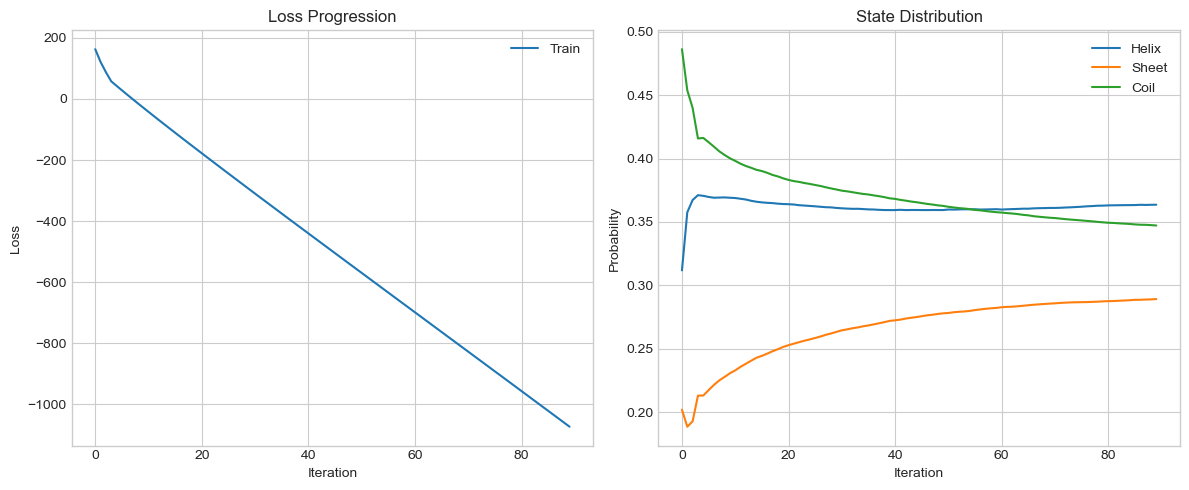

In [2]:

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from dataclasses import dataclass, field
from typing import Dict, List, Optional, Tuple, Any
import logging
from pathlib import Path
import warnings
from datetime import datetime
import time
from collections import defaultdict
from enum import Enum, auto
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tqdm import tqdm


@dataclass
class CRFModelStats:
    """Statistics tracking for CRF model"""
    iteration: int = 0
    log_likelihood: float = 0.0
    state_counts: np.ndarray = None
    feature_weights: Dict[str, float] = None
    convergence_metrics: Dict[str, float] = None
    training_time: float = 0.0




"""
Gradient-Aware Scaling: Handles our large gradient norms (around 100) by scaling to an optimal target range
State Balance Boosting: Uses CB513 state distribution targets to boost learning when states are imbalanced
Smart Warmup: Crucial for stabilizing initial high gradients we're seeing
Local Minima Escape: Detects cyclic patterns and boosts LR to escape local minima, helpful for transition learning
Adaptive Patience: Adjusts patience based on improvement magnitude, useful for our varying convergence patterns
Multi-Factor Combination: Carefully balances multiple optimization needs:

** Gradient magnitude normalization. State distribution improvement. Loss progression. Cycle detection.
"""

class LRScheduler:
    """Advanced learning rate scheduler with multi-factor adaptation"""
    def __init__(self, initial_lr: float = 0.005, min_lr: float = 1e-6):
        # Core parameters
        self.initial_lr = initial_lr
        self.min_lr = min_lr
        self.max_lr = initial_lr * 5.0
        
        # Adaptation tracking
        self.best_loss = float('inf')
        self.loss_history = []
        self.plateau_count = 0
        self.patience = 3
        
        # State balance targets (from CB513 analysis)
        self.target_state_dist = np.array([0.492, 0.162, 0.346])
        
        # Warmup
        self.warmup_epochs = 2
        self.current_epoch = 0
        
        # Cyclic minimums tracking
        self.cycle_min_loss = float('inf')
        self.cycles_without_improvement = 0
        self.max_cycles_plateau = 2

    def get_lr(self, epoch: int, epoch_stats: Dict) -> float:
        """Compute adaptive learning rate based on multiple factors"""
        self.current_epoch = epoch
        current_loss = epoch_stats['epoch_loss'] / max(epoch_stats['n_batches'], 1)
        avg_grad_norm = epoch_stats['grad_norm_total'] / max(epoch_stats['n_batches'], 1)
        state_dist = epoch_stats['state_confidence'] / np.sum(epoch_stats['state_confidence'])

        # Track loss history
        self.loss_history.append(current_loss)
        
        # 1. Warmup phase
        if epoch < self.warmup_epochs:
            return self.initial_lr * ((epoch + 1) / self.warmup_epochs)
        
        # 2. Compute core adjustment factors
        gradient_factor = self._compute_gradient_factor(avg_grad_norm)
        state_factor = self._compute_state_balance_factor(state_dist)
        progress_factor = self._compute_progress_factor(current_loss)
        cycle_factor = self._compute_cycle_escape_factor()
        
        # 3. Combine factors with stability checks
        base_lr = self.initial_lr * gradient_factor * state_factor * progress_factor * cycle_factor
        
        # 4. Apply bounds with adaptive limits
        bounded_lr = min(max(base_lr, self.min_lr), self.max_lr)
        
        # 5. Update internal state
        self._update_tracking(current_loss, bounded_lr)
        
        return bounded_lr

    def _compute_gradient_factor(self, grad_norm: float) -> float:
        """Scale based on gradient magnitude"""
        target_norm = 50.0  # Based on our observed gradient patterns
        return np.clip(target_norm / max(grad_norm, 1e-7), 0.1, 10.0)

    def _compute_state_balance_factor(self, state_dist: np.ndarray) -> float:
        """Penalize state distribution deviation"""
        deviation = np.abs(state_dist - self.target_state_dist).mean()
        balance_factor = 1.0 / (1.0 + deviation * 5)  # Stronger penalty for imbalance
        return np.clip(balance_factor, 0.1, 2.0)

    def _compute_progress_factor(self, current_loss: float) -> float:
        """Analyze loss progression patterns"""
        if current_loss < self.best_loss:
            self.best_loss = current_loss
            self.plateau_count = 0
            return 1.2  # Reward improvement
        
        self.plateau_count += 1
        if self.plateau_count >= self.patience:
            return 0.8  # Reduce on plateau
        return 1.0

    def _compute_cycle_escape_factor(self) -> float:
        """Handle cyclic patterns and local minima"""
        if len(self.loss_history) >= 5:
            recent_min = min(self.loss_history[-5:])
            if recent_min < self.cycle_min_loss:
                self.cycle_min_loss = recent_min
                self.cycles_without_improvement = 0
                return 1.0
            
            self.cycles_without_improvement += 1
            if self.cycles_without_improvement >= self.max_cycles_plateau:
                return 2.0  # Aggressive escape from local minimum
        return 1.0

    def _update_tracking(self, current_loss: float, current_lr: float) -> None:
        """Update internal tracking state"""
        # Keep loss history manageable
        if len(self.loss_history) > 10:
            self.loss_history = self.loss_history[-10:]
            
        # Adapt patience based on progress
        if current_loss < self.best_loss * 0.95:  # Significant improvement
            self.patience = max(self.patience - 1, 2)  # Become more aggressive
        else:
            self.patience = min(self.patience + 1, 5)  # Become more patient

            






# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
        
class ProteinCRF:
    """Linear-chain CRF for protein secondary structure prediction"""
    
    def __init__(self, config: CRFConfig):
        self.config = config
        self.stats = CRFModelStats()
        
        # Initialize model parameters --- # Update feature dimension calculation
        self.base_features = 45  # Original features (one-hot: 21, pssm: 21, position: 3)
        self.beta_features = 22  # Beta sheet features (interactions: 21, propensity: 1)
        self.structural_features = 2  # Hydrophobicity + conservation
        self.context_features = (self.config.window_size * 21)  # Window context from PSSM
        
        ## self.n_features = base_features + beta_features + structural_features + context_features
        self.n_features = self.base_features + self.beta_features + self.structural_features + self.context_features

        self.n_states = 3  # Helix, Sheet, Coil

        # Initialize weights and transitions with careful bounds        
        # Initialize weights with correct dimensions
        self.weights = torch.randn(self.n_states, self.n_features) * 0.1
        self.weights.requires_grad = True

        # Validate total features - now 342 with window_size 13
        expected_features = 69 + (self.config.window_size * 21)  # 69 base + context
        if self.n_features != expected_features:
            raise ValueError(f"Feature dimension mismatch. Expected {expected_features}, got {self.n_features}")

        # Feature group indices for targeted processing
        self.feature_ranges = {
            'one_hot': slice(0, 21),
            'pssm': slice(21, 42),
            'position': slice(42, 45),     # position features
            'beta': slice(45, 67),         # 22 beta features (21 interactions + 1 propensity)
            'structural': slice(67, 69),   #  2 structural features (hydrophobicity + conservation)
            'context': slice(69, self.n_features) ## Context features (calculated from window_size * 21)
        }
        

        # Validate feature ranges
        total_range = sum(r.stop - r.start for r in self.feature_ranges.values())
        if total_range != self.n_features:
            raise ValueError(f"Feature ranges sum ({total_range}) doesn't match n_features ({self.n_features})")


        # Initialize transitions with careful bounds
        ## self.transitions = torch.randn(self.n_states, self.n_states) * 0.1
        self._initialize_transitions()  # replaces: 

        
        self.transitions.requires_grad = True
        
        # Setup optimizer with both parameter sets
        self.params = [self.weights, self.transitions]
        self.optimizer = torch.optim.Adam(self.params, lr=config.learning_rate)

        # Initialize statistics tracking
        self.history = defaultdict(list)
        
        self.logger = setup_logger("protein_structure")

            
    def _initialize_transitions(self) -> None:
        """Initialize transitions based on CB513 dataset statistics"""
        # Initialize with empirical probabilities from dataset analysis
        self.transitions = torch.zeros(self.n_states, self.n_states)
        
        # Self-transitions (from dataset statistics)
        self.transitions[0, 0] = 0.91  # H→H (from alpha helix stability)
        self.transitions[1, 1] = 0.67  # E→E (from beta sheet continuity)
        self.transitions[2, 2] = 0.39  # C→C (from coil flexibility)
        
        # Cross-state transitions (computed from dataset)
        # Helix transitions
        self.transitions[0, 1] = 0.05  # H→E (rare in dataset)
        self.transitions[0, 2] = 0.04  # H→C (terminal regions)
        
        # Sheet transitions
        self.transitions[1, 0] = 0.13  # E→H (beta-alpha motifs)
        self.transitions[1, 2] = 0.20  # E→C (sheet termination)
        
        # Coil transitions
        self.transitions[2, 0] = 0.31  # C→H (helix initiation)
        self.transitions[2, 1] = 0.30  # C→E (sheet initiation)
        
        # Add small noise for symmetry breaking (but maintain dominant patterns)
        noise = torch.randn_like(self.transitions) * 0.01
        self.transitions += noise
        
        # Log-space conversion for numerical stability
        self.transitions = F.log_softmax(self.transitions, dim=1)
        self.transitions.requires_grad = True
        
        # # Log initial statistics
        # self.logger.info("Initialized transitions from CB513 statistics:")
        # with torch.no_grad():
        #     trans_probs = torch.exp(self.transitions)
        #     self.logger.info(f"Self-transitions - H→H: {trans_probs[0,0]:.3f}, "
        #                     f"E→E: {trans_probs[1,1]:.3f}, C→C: {trans_probs[2,2]:.3f}")
        #     self.logger.info(f"Major cross-transitions - C→H: {trans_probs[2,0]:.3f}, "
        #                     f"C→E: {trans_probs[2,1]:.3f}, E→C: {trans_probs[1,2]:.3f}")

    
    def _compute_transition_loss(self, labels: torch.Tensor, valid_positions: List[torch.Tensor]) -> Tuple[torch.Tensor, Dict[str, Any]]:
        """Compute transition loss and collect transition statistics. Implementation focuses on horizontal clarity."""
        transition_loss = torch.zeros(1, device=labels.device); trans_counts = torch.zeros((self.n_states, self.n_states), device=labels.device); 
        batch_size = len(valid_positions); total_transitions = 0;
        
        # Process each sequence in batch using valid positions
        for b in range(batch_size):
            valid_pos = valid_positions[b]; seq_len = len(valid_pos)
            # Extract valid states for this sequence
            seq_states = labels[b, valid_pos]
            
            # Count transitions and compute loss for valid positions
            for t in range(seq_len - 1):
                prev_state, curr_state = seq_states[t], seq_states[t + 1]
                trans_counts[prev_state, curr_state] += 1; total_transitions += 1
                transition_loss -= self.transitions[prev_state, curr_state]  # Add to negative log likelihood
        
        # Normalize transition counts and compute statistics
        trans_probs = trans_counts / (total_transitions + 1e-10)
        transition_stats = {'counts': trans_counts.cpu().numpy(), 'probabilities': trans_probs.cpu().numpy(), 'total_transitions': total_transitions}
        
        # Add state-specific transition statistics
        for state in range(self.n_states):
            state_trans = trans_probs[state]
            transition_stats[f'state_{state}_distribution'] = state_trans.cpu().numpy()
            transition_stats[f'state_{state}_entropy'] = -torch.sum(state_trans * torch.log(state_trans + 1e-10)).item()
        
        # Normalize total loss
        avg_transition_loss = transition_loss / max(total_transitions, 1)
        
        return avg_transition_loss, transition_stats

    
    def _get_valid_positions(self, seq_data: torch.Tensor) -> List[int]:
        """Identify valid positions in a sequence based on feature values."""

        ## -> called too often, dont log. self.logger.info(f"seq_data type: {type(seq_data)}") 
        if isinstance(seq_data, torch.Tensor):
            one_hot_sums = torch.sum(seq_data[:, :21], dim=1)
        elif isinstance(seq_data, np.ndarray):
            one_hot_sums = np.sum(seq_data[:, :21], axis=1)
        else:
            raise ValueError("seq_data must be a torch.Tensor or np.ndarray")
        
        valid_positions = (one_hot_sums > 0).nonzero(as_tuple=False).squeeze(-1)
        return valid_positions.tolist()

        
    def _validate_dimensions(self, x: torch.Tensor, stage: str = ""):
        """Validate tensor dimensions with updated feature count"""
        if x is None:
            raise ValueError(f"{stage}: Input tensor is None")
        
        shape = x.shape
        if len(shape) < 2:
            raise ValueError(f"{stage}: Expected at least 2D tensor, got {len(shape)}D")
            
        expected_features = 69 + (self.config.window_size * 21)
        if shape[-1] != expected_features and stage == "features":
            raise ValueError( f"{stage}: Feature dimension mismatch. Expected {expected_features}, "
                f"got {shape[-1]}. Window size: {self.config.window_size}" )


    
    def _compute_features(self, x: torch.Tensor) -> torch.Tensor:
        """Compute feature scores for each state with enhanced feature handling"""

        try:
            self._validate_dimensions(x, "feature input")
    
            if x.size(-1) != self.n_features:
                ## -- raise ValueError(f"Expected {self.n_features} features, got {x.size(-1)}. Check if beta and structural features are included.")
                self.logger.error(f"Feature dimension mismatch: expected {self.n_features}, got {x.size(-1)}")
                self.logger.error(f"Feature ranges: {[(k, v) for k, v in self.feature_ranges.items()]}")
                raise ValueError(f"Feature dimension mismatch")

            # Enhanced feature scoring with group-specific handling
            feature_scores = torch.zeros(x.size(0), self.n_states)
            # Base features (one-hot + PSSM): Use original weights
            base_scores = torch.matmul(x[:, :42], self.weights[:, :42].t())
            
            # Beta pattern features: Boost importance for sheet state
            beta_start, beta_end = 42, 64  # 21 interactions + 1 propensity
            beta_scores = torch.matmul(x[:, beta_start:beta_end], self.weights[:, beta_start:beta_end].t())
            beta_boost = torch.tensor([1.0, 1.5, 1.0])  # Boost sheet state
            beta_scores = beta_scores * beta_boost.unsqueeze(0)
            
            # Structural features: Standard weighting
            struct_start, struct_end = 64, 66
            struct_scores = torch.matmul(x[:, struct_start:struct_end], self.weights[:, struct_start:struct_end].t())
            # Context features: 
            context_scores = torch.matmul(x[:, struct_end:], self.weights[:, struct_end:].t())
            # Combine all scores with stability check
            feature_scores = base_scores + beta_scores + struct_scores + context_scores
            
            if torch.isnan(feature_scores).any() or torch.isinf(feature_scores).any():    self.logger.warning("Numerical instability in feature computation")
            
            return feature_scores
            
        except Exception as e:
            self.logger.error(f"Feature computation failed: {str(e)}")
            raise


        
    def _compute_partition(self, feature_scores: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """Compute partition function with numerical stability"""
        batch_size, seq_len, _ = feature_scores.shape
        alpha = torch.zeros(batch_size, seq_len, self.n_states)
        
        # Initialize first position
        alpha[:, 0] = feature_scores[:, 0]
        
        # Forward recursion with improved stability
        for t in range(1, seq_len):
            next_scores = feature_scores[:, t].unsqueeze(1)  # [batch, 1, n_states]
            trans_scores = self.transitions  # [n_states, n_states]
            # Compute max scores for stability
            max_prev = alpha[:, t-1].unsqueeze(-1)  # [batch, n_states, 1]
            max_scores = max_prev + next_scores + trans_scores
            alpha[:, t] = torch.logsumexp(max_scores, dim=1)
        
        # Return alpha and partition
        return alpha, torch.logsumexp(alpha[:, -1], dim=1)

    
        
    def _compute_gold_score(self, feature_scores: torch.Tensor, labels: torch.Tensor) -> torch.Tensor:
        """Compute score for the correct sequence with enhanced features"""
        batch_size, seq_len, _ = feature_scores.shape
        gold_score = torch.zeros(batch_size)
        
        # Add feature scores
        for t in range(seq_len):
            gold_score += torch.gather(feature_scores[:, t], 1, labels[:, t].unsqueeze(1)).squeeze(1)
        
        # Add transition scores with boundary checks
        for t in range(seq_len - 1):
            trans_score = self.transitions[labels[:, t], labels[:, t+1]]
            gold_score += trans_score
            
        if torch.isnan(gold_score).any():
            self.logger.warning("NaN values detected in gold score computation")
        
        return gold_score

        
    def _update_stats(self, loss: float, predictions: torch.Tensor, labels: torch.Tensor):
        """Update training statistics"""
        self.stats.iteration += 1
        self.stats.log_likelihood = -loss
        
        # Update state counts
        pred_states = predictions.detach().numpy()
        self.stats.state_counts = np.bincount(pred_states.flatten(), minlength=self.n_states)
        state_dist = self.stats.state_counts / np.sum(self.stats.state_counts)
        
        # Check for state collapse
        if np.any(state_dist < self.config.min_state_prob):
            self.logger.warning(f"Low state probability detected: {state_dist}")
        
        # Track feature weights
        with torch.no_grad():
            weight_norms = torch.norm(self.weights, dim=1)
            self.stats.feature_weights = {f"state_{i}": w.item() for i, w in enumerate(weight_norms)}
        
        # Update history
        self.history['loss'].append(loss)
        self.history['state_dist'].append(state_dist)
        self.history['weight_norms'].append([w.item() for w in weight_norms])
    
    
    
    def _check_convergence(self, epoch_stats: Dict) -> bool:
        """Enhanced convergence check with validation metrics"""
        if len(self.history['loss']) < 2:
            return False
        
        current_loss = self.history['loss'][-1]
        prev_loss = self.history['loss'][-2]
        loss_change = abs(current_loss - prev_loss)
        
        # Also check validation metrics if available
        if 'val_metrics' in epoch_stats:
            val_loss = epoch_stats['val_metrics'].get('loss', float('inf'))
            self.history.setdefault('best_val_loss', float('inf'))
            
            if val_loss < self.history['best_val_loss']:
                self.history['best_val_loss'] = val_loss
                self.history['convergence_patience'] = 0
            else:
                self.history.setdefault('convergence_patience', 0)
                self.history['convergence_patience'] += 1
                
            # Early stop if validation loss hasn't improved
            if self.history['convergence_patience'] >= 5:  # Patience threshold
                return True
        
        return loss_change < self.config.convergence_tol
        

    def _validate_forward_stats(self, forward_stats: Dict[str, Any]) -> bool:
        """Validate forward statistics dictionary"""
        required_keys = {'feature_importance', 'stability_metrics', 'alpha_norms'}
        
        if not all(key in forward_stats for key in required_keys):
            missing = required_keys - set(forward_stats.keys())
            self.logger.error(f"Missing forward stats keys: {missing}")
            return False
            
        return True

        
    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, Dict[str, Any]]:
        """Enhanced forward pass with feature group handling and monitoring"""
        batch_size, seq_len = x.size(0), x.size(1)
        
        # Process feature groups separately
        feature_scores = torch.zeros(batch_size, seq_len, self.n_states)
        feature_importance = {}
        aggregated_feature_scores = np.zeros(self.n_features)  # Correct shape (258,)

        try:
            # Track each feature group's contribution
            for name, feat_slice in self.feature_ranges.items():
                ## old: group_scores = torch.matmul(x[..., feat_slice], self.weights[:, feat_slice].t())
                # Compute group scores
                group_x = x[..., feat_slice]
                group_weights = self.weights[:, feat_slice]
                group_scores = torch.matmul(group_x, group_weights.t())

                # Apply feature weights
                weighted_scores = group_scores * self.config.feature_weights.get(name, 1.0)
                feature_scores += weighted_scores

                # Track feature importance (per feature, not per state)
                with torch.no_grad():
                    # Compute feature-wise importance
                    feat_importance = torch.abs(group_x).mean(dim=(0, 1)).cpu().numpy()
                    feature_importance[name] = feat_importance
                    
                    # Accumulate to feature scores (maintaining feature dimensionality)
                    start_idx = feat_slice.start
                    end_idx = feat_slice.stop
                    aggregated_feature_scores[start_idx:end_idx] = feat_importance
    
            # Compute partition with stability checks. Initialize alpha (forward variables) in log-space.
            alpha = torch.zeros(batch_size, seq_len, self.n_states)
            alpha[:, 0] = feature_scores[:, 0]
            
            # Forward recursion with enhanced monitoring. Forward recursion with log-space computations.
            stability_metrics = {'max_scores': [], 'min_scores': []}
            for t in range(1, seq_len):
                prev_scores = alpha[:, t-1].unsqueeze(2)  # [batch, n_states, 1]
                trans_scores = self.transitions.unsqueeze(0)  # [1, n_states, n_states]
                curr_scores = feature_scores[:, t].unsqueeze(1)  # [batch, 1, n_states]

                # combined scores calculation.
                combined = prev_scores + trans_scores + curr_scores
                # Log-space computation with stability tracking
                max_vals = torch.max(combined, dim=1)[0]

                
                stability_metrics['max_scores'].append(max_vals.max().item())
                stability_metrics['min_scores'].append(max_vals.min().item())

                # Use log_sum_exp for numerical stability
                alpha[:, t] = torch.logsumexp(combined, dim=1)
            
            # Compute partition with careful normalization. In logspace again. 
            partition = torch.logsumexp(alpha[:, -1], dim=1)
    
    
            # Return with correct feature score shape
            forward_stats = {
                'feature_scores': aggregated_feature_scores,  # Shape: (258,)
                'feature_details': feature_importance,
                'stability_metrics': stability_metrics,
                'alpha_norms': torch.norm(alpha, dim=-1).mean(dim=0).tolist()
            }


            return feature_scores, partition, forward_stats
            
        except Exception as e:
            self.logger.error(f"Forward pass failed: {str(e)}, input shape: {x.shape}", exc_info = True)
            raise
            
    

        
    def _compute_loss(self, batch_x: torch.Tensor, batch_y: torch.Tensor) -> torch.Tensor:
        """Compute CRF loss with regularization"""
        feature_scores, partition = self.forward(batch_x)
        gold_score = self._compute_gold_score(feature_scores, batch_y)
        
        # Negative log likelihood
        loss = partition - gold_score
        
        # Add regularization
        if self.config.l1_penalty > 0:
            loss = loss + self.config.l1_penalty * torch.norm(self.weights, p=1)
        if self.config.l2_penalty > 0:
            loss = loss + self.config.l2_penalty * torch.norm(self.weights, p=2)
            
        return loss.mean()

    ## -------------------------------------------------------------------------------------------------------------------------------------------------------------
                
    def _initialize_training(self, sequences: List[np.ndarray], labels: List[np.ndarray]) -> Tuple[List[torch.Tensor], List[torch.Tensor], Dict]:
        """Initialize training data and tracking structures"""
        x_data = [torch.FloatTensor(x) for x in sequences]
        y_data = [torch.LongTensor(np.argmax(y, axis=1)) for y in labels]
        
        # Enhanced history structure --- 'stability_metrics', 'state_confidence', 'feature_contributions', 'total_valid_positions'

        history = {
            'loss': [], 'state_dist': [], 'feature_importance': [],
            'transition_probs': [], 'transition_counts': [], 
            'confidence': [], 'gradient_norms': [],
            'learning_rates': [], 'parameter_norms': [], 'sequence_stats': [], 

            ## i think these mayb not be needed here cuz already declared in epoch stats dictonary.
            'stability_metrics': [], 'state_confidence': [], 'feature_contributions': [], 'total_valid_positions': [], 
        }
        
        return x_data, y_data, history

        
    
    def _initialize_epoch_stats(self) -> Dict:
        """Initialize statistics for one epoch with correct dimensions"""
        return {
            'feature_scores': np.zeros(self.n_features),  # Per-feature contributions
            'feature_details': defaultdict(float),        # Group-level tracking
            'transition_usage': np.zeros((self.n_states, self.n_states)),
            'transition_counts': np.zeros((self.n_states, self.n_states)),
            'state_confidence': np.zeros(self.n_states),
            'sequence_lengths': [],
            'batch_metrics': [],
            'epoch_loss': 0.0,
            'grad_norm_total': 0.0,
            'n_batches': 0,
            'total_valid_positions': 0,
            'stability_metrics': {'min_val': float('inf'), 'max_val': float('-inf')}
        }
            ## 'feature_contributions': np.zeros(self.n_features)
    


    
            
    def _update_history(self, history: Dict, epoch_stats: Dict, current_lr: float) -> None:
        """Update training history with comprehensive metrics tracking"""
        # Basic metrics
        history['loss'].append(epoch_stats['epoch_loss'] / max(epoch_stats['n_batches'], 1))
        history['learning_rates'].append(current_lr)
        
        # State distribution evolution
        history['state_dist'].append(epoch_stats['state_confidence'] / np.sum(epoch_stats['state_confidence']))
        
        # Feature importance tracking by group
        feature_scores = epoch_stats['feature_scores']  # now the 258-dim array

        history['feature_importance'].append({
            'one_hot': np.mean(feature_scores[:21]),
            'pssm': np.mean(feature_scores[21:42]),
            'position': np.mean(feature_scores[42:45]),
            'beta': np.mean(feature_scores[45:67]),
            'structural': np.mean(feature_scores[67:69]),
            'context': np.mean(feature_scores[69:]),
        
            'mean': feature_scores / max(epoch_stats['n_batches'], 1),
            'details': epoch_stats['feature_details']  
        })
        
        # Track transition dynamics
        history['transition_probs'].append(epoch_stats['transition_usage'] / np.sum(epoch_stats['transition_usage']))
        history['transition_counts'].append(epoch_stats['transition_counts'])
        
        # Detailed confidence tracking
        confidence_stats = np.array([b['prediction_confidence'] for b in epoch_stats['batch_metrics']])

        
        history['confidence'].append({ 
            'mean': np.mean(confidence_stats), 'std': np.std(confidence_stats), 'min': np.min(confidence_stats), 'max': np.max(confidence_stats) })
        
        # Track gradient behavior
        grad_stats = np.array([b['gradient_norm'] for b in epoch_stats['batch_metrics']])
        history['gradient_norms'].append({
            'mean': np.mean(grad_stats),
            'std': np.std(grad_stats),
            'max': np.max(grad_stats)
        })
        
        # Stability metrics
        stability_metrics = epoch_stats.get('stability_metrics', {})

        history['stability_metrics'].append({
            'score_range': [ stability_metrics.get('min_val', float('inf')), stability_metrics.get('max_val', float('-inf')) ],
            'valid_positions': epoch_stats.get('total_valid_positions', 0), 'avg_seq_length': epoch_stats.get('avg_seq_length', 0)  })
        
        # Weight evolution tracking (with detachment)
        with torch.no_grad():
            weight_norms = torch.norm(self.weights, dim=1)
            transition_norms = torch.norm(self.transitions, dim=1)
            history['parameter_norms'].append({
                'weights': weight_norms.cpu().numpy(),
                'transitions': transition_norms.cpu().numpy()
            })
        
        # Sequence statistics
        history['sequence_stats'].append({
            'lengths': epoch_stats['sequence_lengths'],
            'length_mean': np.mean(epoch_stats['sequence_lengths']),
            'length_std': np.std(epoch_stats['sequence_lengths'])
        })
        
        # Track validation metrics if present
        if 'val_metrics' in epoch_stats:
            val_metrics = epoch_stats['val_metrics']
            
            # Initialize validation metric tracking if needed
            for metric in ['loss', 'accuracy', 'mean_confidence']:
                if f'val_{metric}' not in history:
                    history[f'val_{metric}'] = []
            
            # Safely append validation metrics
            history['val_loss'].append(val_metrics.get('loss', float('inf')))
            history['val_accuracy'].append(val_metrics.get('accuracy', 0.0))
            history['val_mean_confidence'].append(val_metrics.get('mean_confidence', 0.0))
            
            # Track per-state metrics
            for state in range(self.n_states):
                state_key = f'val_f1_state_{state}'
                if state_key not in history:
                    history[state_key] = []
                history[state_key].append(val_metrics.get(f'f1_state_{state}', 0.0))
        
        return history

            
        
    def fit(self, sequences: List[np.ndarray], labels: List[np.ndarray], validation_data: Optional[Tuple] = None) -> Dict[str, Any]:
        """Train the CRF model with enhanced monitoring and LR scheduling"""
        self.logger.info("Starting CRF training")
        x_data, y_data, history = self._initialize_training(sequences, labels)
        n_samples = len(sequences)
        
        # Initialize LR scheduler
        lr_scheduler = LRScheduler(self.config.learning_rate, min_lr=1e-5)
        
        for epoch in range(self.config.max_iterations):
            epoch_stats = self._initialize_epoch_stats()

            ## progress bar update thingy :) this is cool. 
            print_freq = max(n_samples // (self.config.batch_size * 10), 1)  
            progress = tqdm( range(0, n_samples, self.config.batch_size), desc=f"Epoch {epoch+1}", ncols=100, miniters=print_freq )
            
            for i in progress:
                # Process batch
                batch_x, batch_y = x_data[i:i + self.config.batch_size], y_data[i:i + self.config.batch_size]
                loss, batch_stats = self._process_batch(batch_x, batch_y)

                # Add logging before the problematic line
                ## self.logger.info(f"epoch_stats['feature_importance'] type: {type(epoch_stats['feature_importance'])}")
                # self.logger.info(f"batch_stats['feature_contributions'] type: {type(batch_stats['feature_contributions'])}")
                # self.logger.info(f"batch_stats keys: {batch_stats.keys()}")

                # Update statistics
                epoch_stats['epoch_loss'] += loss.item()
                epoch_stats['grad_norm_total'] += batch_stats['gradient_norm']
                epoch_stats['n_batches'] += 1
                epoch_stats['feature_scores'] += batch_stats['feature_scores']  # Both (258,)

                ## epoch_stats['feature_importance'] += batch_stats['feature_contributions']
                for feat_name, feat_value in batch_stats['feature_details'].items():
                    epoch_stats['feature_details'][feat_name] += feat_value
                epoch_stats['transition_usage'] += batch_stats['transition_counts']
                epoch_stats['state_confidence'] += batch_stats['state_confidence']
                epoch_stats['sequence_lengths'].extend(batch_stats['seq_lengths'])
                epoch_stats['batch_metrics'].append(batch_stats)
                epoch_stats['total_valid_positions'] = sum(batch_stats['seq_lengths'])

                batch_stability = batch_stats.get('stability_metrics', {})
                
                epoch_stats['stability_metrics']['min_val'] = min(
                    epoch_stats['stability_metrics']['min_val'], batch_stability.get('min_val', float('inf')) )
                epoch_stats['stability_metrics']['max_val'] = max(
                    epoch_stats['stability_metrics']['max_val'], batch_stability.get('max_val', float('-inf')) )

                # Update progress bar
                progress.set_postfix({'loss': epoch_stats['epoch_loss'] / max(epoch_stats['n_batches'], 1)})
            
            # Compute validation metrics if validation data provided
            if validation_data:
                val_seq, val_labels = validation_data
                val_metrics = self.evaluate(val_seq, val_labels)
                epoch_stats['val_metrics'] = val_metrics
            
            # Update learning rate
            new_lr = lr_scheduler.get_lr(epoch, epoch_stats)
            for param_group in self.optimizer.param_groups:
                param_group['lr'] = new_lr
                
            # Update history and log
            self._update_history(history, epoch_stats, new_lr)
            self._log_epoch_summary(epoch, epoch_stats, new_lr)
            
            # Check for early stopping
            if self._check_convergence(epoch_stats):
                self.logger.info(f"Converged after {epoch+1} epochs")
                break
        
        return history

        
    def _log_epoch_summary(self, epoch: int, stats: Dict, current_lr: float) -> None:
        """Enhanced epoch logging with comprehensive metrics in horizontal format"""
        # Core metrics
        avg_loss = stats['epoch_loss'] / max(stats['n_batches'], 1); state_usage = stats['state_confidence'] / np.sum(stats['state_confidence']); avg_grad = stats['grad_norm_total'] / max(stats['n_batches'], 1)
        
        # Average loss components across batches
        loss_components = defaultdict(float)
        for batch in stats['batch_metrics']:
            for k, v in batch.get('loss_components', {}).items():
                if isinstance(v, (int, float)):
                    loss_components[k] += v
        loss_components = {k: v/stats['n_batches'] for k, v in loss_components.items()}


        # Calculate average sequence length if not already present
        if 'avg_seq_length' not in stats and 'sequence_lengths' in stats:
            stats['avg_seq_length'] = np.mean(stats['sequence_lengths'])
        avg_seq_length = stats.get('avg_seq_length', 0.0)

        # Detailed statistics
        grad_norms = [b['gradient_norm'] for b in stats['batch_metrics']]; 
        conf_scores = [b['prediction_confidence'] for b in stats['batch_metrics']];


        trans_probs = stats['transition_usage'] / np.sum(stats['transition_usage'])
        # Prepare transitions string (sorted by probability)
        transitions = [('H→H', trans_probs[0,0]), ('E→E', trans_probs[1,1]), ('C→C', trans_probs[2,2])]
        trans_str = ', '.join([f"{name}: {prob:.3f}" for name, prob in sorted(transitions, key=lambda x: x[1], reverse=True)])
                
        # Feature importance logging
        feat_imp = []
        for name, value in stats['feature_details'].items():
            feat_imp.append(f"{name}: {np.mean(value):.3f}")

        self.logger.info(f"Features [{', '.join(feat_imp)}]")
        
        # Log main metrics
        self.logger.info(
            f"\nEpoch {epoch+1}/{self.config.max_iterations} | "
            f"Loss: {avg_loss:.4f} (Base: {loss_components.get('base_loss', 0):.4f}, | LR: {current_lr:.6f} "
            f"Trans: {loss_components.get('transition_loss', 0):.4f}, "
            f"Balance: {loss_components.get('balance_loss', 0):.4f}, "
            f"L2: {loss_components.get('l2_loss', 0):.4f}) | "
            ## f"States [H: {state_usage[0]:.3f}, E: {state_usage[1]:.3f}, C: {state_usage[2]:.3f}] | "
            ## f"Transitions [{trans_str}]"
        )
        
        # State distribution and transitions
        self.logger.info(
            f"States [H: {state_usage[0]:.3f}, E: {state_usage[1]:.3f}, C: {state_usage[2]:.3f}] | "
            f"Transitions [{stats.get('transition_stats', {}).get('probabilities', [[0]*3]*3)}]"
        )

        # Log detailed stats
        self.logger.info(
            f"Details | "
            f"Grad: {np.mean(grad_norms):.3f}±{np.std(grad_norms):.3f} | "
            f"Conf: {np.mean(conf_scores):.3f} (min: {np.min(conf_scores):.3f}, max: {np.max(conf_scores):.3f}) | "
            f"Seq Len: {np.mean(stats['sequence_lengths']):.1f}±{np.std(stats['sequence_lengths']):.1f}"
        )
        
        # Stability metrics logging with safe access
        stability_metrics = stats.get('stability_metrics', {})
        self.logger.info(
            f"Stability | "
            f"Score Range: [{stability_metrics.get('min_val', 0):.3f}, {stability_metrics.get('max_val', 0):.3f}] | "
            f"Valid Positions: {stats.get('total_valid_positions', 0)} | "
            f"Avg Seq Length: {avg_seq_length:.1f}" )

        # Log detailed transition analysis
        trans_counts = stats['transition_counts']
        trans_details = [
            f"H→E: {trans_counts[0,1]:.0f}", f"H→C: {trans_counts[0,2]:.0f}",
            f"E→H: {trans_counts[1,0]:.0f}", f"E→C: {trans_counts[1,2]:.0f}",
            f"C→H: {trans_counts[2,0]:.0f}", f"C→E: {trans_counts[2,1]:.0f}"
        ]
        self.logger.info(f"Transitions | {' | '.join(trans_details)}")
        
        # Log state confidence details
        confidence_by_state = [
            f"H: {np.mean([b.get('state_confidence', [0,0,0])[0] for b in stats['batch_metrics']]):.3f}",
            f"E: {np.mean([b.get('state_confidence', [0,0,0])[1] for b in stats['batch_metrics']]):.3f}",
            f"C: {np.mean([b.get('state_confidence', [0,0,0])[2] for b in stats['batch_metrics']]):.3f}"
        ]
        self.logger.info(f"State Confidence | {' | '.join(confidence_by_state)}")

    
    
    """
        # # Fill padded tensors
        # for j, (x, y) in enumerate(zip(batch_x, batch_y)):
        #     # Ensure x has correct feature dimension before assignment
        #     if x.size(1) != self.n_features:
        #         # Add context features if needed
        #         x = self._add_context_features(x)
        #     batch_x_padded[j, :x.size(0)] = x
        #     batch_y_padded[j, :y.size(0)] = y
    """
    
        
    ### need to detach the tensors before converting to numpy arrays since they have gradients. # fix error.
        
    def _collect_batch_metrics(self, feature_scores: torch.Tensor,  valid_positions: List[torch.Tensor], 
                               forward_stats: Dict[str, Any], grad_norm: float) -> Dict[str, Any]:
        """Helper method to collect comprehensive batch statistics with valid position tracking"""
        
        batch_size = feature_scores.size(0)
        # predictions and probabilities
        pred_probs = F.softmax(feature_scores, dim=-1); pred_states = pred_probs.argmax(dim=-1)
        # init tracking
        state_conf = torch.zeros(self.n_states); trans_counts = torch.zeros((self.n_states, self.n_states)); total_valid = 0; 
        confidences = []; feature_contribs = []; stability_values = []
        
        # Process each sequence using valid positions
        for i in range(batch_size):
            
            valid_pos = valid_positions[i]; total_valid += len(valid_pos); 
            # states and probabilities for valid positions
            seq_states = pred_states[i, valid_pos]; seq_probs = pred_probs[i, valid_pos];
            # State distribution and confidence tracking
            for state in range(self.n_states): state_conf[state] += (seq_states == state).float().sum()
            # Track prediction confidence
            confidences.append(seq_probs.max(dim=1)[0].mean().item())
            
            # Track transitions between valid positions
            for t in range(len(valid_pos) - 1): 
                trans_counts[seq_states[t], seq_states[t + 1]] += 1
            
            # Feature contribution tracking using forward_stats
            if 'feature_importance' in forward_stats: 
                feat_importance = [forward_stats['feature_importance'].get(feat, 0.0) for feat in self.feature_ranges.keys()]
                feature_contribs.append(feat_importance)

            
            stability_max = []; stability_min = []; 
            # Process each sequence's stability values properly
            for t in range(len(valid_pos)):
                if 'stability_metrics' in forward_stats:
                    max_scores = forward_stats['stability_metrics'].get('max_scores', [])
                    min_scores = forward_stats['stability_metrics'].get('min_scores', [])
                    if t < len(max_scores): stability_max.append(max_scores[t])
                    if t < len(min_scores): stability_min.append(min_scores[t])
            stability_metrics = { 'max_val': np.max(stability_max) if stability_max else 0, 'min_val': np.min(stability_min) if stability_min else 0 }

            # # Track stability metrics from forward pass
            # if 'stability_metrics' in forward_stats: 
            #     stability_values.extend([forward_stats['stability_metrics'].get('max_scores', [])[-len(valid_pos):], 
            #                              forward_stats['stability_metrics'].get('min_scores', [])[-len(valid_pos):]])
            # -----------------------------------------------------------------------------------------------------------------------------------------


        # Ensure feature_scores maintains correct shape (258,)
        assert forward_stats['feature_scores'].shape == (self.n_features,), \
            f"Feature scores shape mismatch. Expected ({self.n_features},), got {forward_stats['feature_scores'].shape}"

        # Normalize and prepare final statistics
        return {
            
            ## v1 'feature_contributions': self.weights.detach().abs().mean(dim=0).cpu().numpy(),
            ## v3 'feature_contributions': torch.mean(feature_scores, dim=(0,1)).detach().cpu().numpy(),
            ## v2 'feature_contributions': forward_stats['feature_importance'].get('mean', np.zeros(self.n_features)),
            ## v4 outdated: 'feature_contributions': torch.mean(feature_scores, dim=(0,1)).detach().cpu().numpy(),  # Direct feature contributions
            ## 'feature_contributions': forward_stats['feature_scores'], 

            'feature_scores': forward_stats['feature_scores'],  # Shape: (258,)
            'feature_details': forward_stats['feature_details'],      
            
            'transition_counts': trans_counts.cpu().numpy(),
            'state_confidence': (state_conf / total_valid).cpu().numpy() if total_valid > 0 else state_conf.cpu().numpy(),
        
            'transition_counts': trans_counts.cpu().numpy(),
            'state_confidence': (state_conf / total_valid).cpu().numpy() if total_valid > 0 else state_conf.cpu().numpy(),
            'seq_lengths': [len(pos) for pos in valid_positions],
            'prediction_confidence': np.mean(confidences),
            'gradient_norm': grad_norm,
            'feature_importance': np.mean(feature_contribs, axis=0) if feature_contribs else None,
            'stability_metrics': {'max_val': np.max(stability_values) if stability_values else 0, 'min_val': np.min(stability_values) if stability_values else 0},
            'batch_size': batch_size,
            'total_valid_positions': total_valid,
            'avg_seq_length': total_valid / batch_size if batch_size > 0 else 0
        }


    """
    ERROR 1 issue: self.n_features = 189 (expected total features) ... Actual features in the data = 186 (likely missing some context).
    RuntimeError: The expanded size of the tensor (189) must match the existing size (186) at non-singleton dimension 1.
    Target sizes: [280, 189].  Tensor sizes: [280, 186].

    """
    def _process_batch(self, batch_x: List[torch.Tensor], batch_y: List[torch.Tensor]) -> Tuple[torch.Tensor, Dict]:
        """Process a single batch with detailed statistics and valid position tracking"""

        try:
            # Get max sequence length in batch
            max_len = max(x.size(0) for x in batch_x);  batch_size = len(batch_x); 
            # Initialize padded tensors
            batch_x_padded = torch.zeros(batch_size, max_len, self.n_features); batch_y_padded = torch.zeros(batch_size, max_len, dtype=torch.long)
            # Track valid positions for each sequence
            valid_positions = []
            expected_features = 69 + (self.config.window_size * 21)
            
            
            # Debug prints -- well, adjust if they happen too often.
            ## self.logger.info(f"Batch processing - batch_size: {batch_size}, max_len: {max_len}, n_features: {self.n_features}")
            ## self.logger.info(f"Batch processing dimensions: n_features: {self.n_features},\t context_features: {self.config.window_size * 21}")
    
            # Fill padded tensors with careful feature handling
            for i, (x, y) in enumerate(zip(batch_x, batch_y)):
                valid_pos = self._get_valid_positions(x); valid_positions.append(valid_pos); seq_len = len(valid_pos);
    
                # Verify input dimensions
                if x.size(1) != expected_features:
                    raise ValueError( f"Sequence {i} has incorrect features: {x.size(1)}, expected {expected_features}" )
    
                # Handle features by group
                curr_pos = 0
                for name, feat_slice in self.feature_ranges.items():
                    feat_width = feat_slice.stop - feat_slice.start
                    batch_x_padded[i, :seq_len, curr_pos:curr_pos + feat_width] = x[valid_pos, feat_slice]
                    curr_pos += feat_width
                    
                batch_y_padded[i, :seq_len] = y[valid_pos]
            
            # Forward pass and loss computation
            self.optimizer.zero_grad()
            # Add dimension check before forward pass ## -- no need, self.logger.info(f"Forward input shape: {batch_x_padded.shape}")
            feature_scores, partition, forward_stats = self.forward(batch_x_padded)
    
            # Compute loss with valid position masking
            loss, loss_stats = self._compute_masked_loss(feature_scores, partition, batch_y_padded, batch_x_padded)
        
            # Backward pass with gradient monitoring
            loss.backward()
            grad_norm = torch.nn.utils.clip_grad_norm_(self.params, max_norm= self.config.max_grad_norm)
            self.optimizer.step()

            ## - gradient norm must be computed WITH gradients as it measures the actual training gradients
            ## -- Other metrics (probabilities, state counts, etc.) are just for monitoring and don't need gradients
            ## keep the torch.no_grad() context for batch metrics collection..
            
            # Collect detailed statistics using valid positions
            with torch.no_grad():
                batch_metrics = self._collect_batch_metrics( feature_scores=feature_scores, valid_positions=valid_positions, forward_stats=forward_stats, grad_norm=grad_norm.item() )
                
                batch_metrics['gradient_norm'] = grad_norm.item()
                batch_metrics.update(forward_stats)

                    # Merge loss statistics with batch metrics
                batch_metrics.update({ 'loss_components': loss_stats, 'grad_norm': grad_norm.item(), 
                                      'feature_contributions': forward_stats['feature_scores'], 'state_balance': loss_stats['state_distribution'] })

            return loss, batch_metrics
            
        except Exception as e:
            self.logger.error(f"Batch processing failed: {str(e)}", exc_info = True)
            raise

    
        
    def _compute_masked_loss(self, feature_scores: torch.Tensor, partition: torch.Tensor, labels: torch.Tensor, batch_x: torch.Tensor) -> Tuple[torch.Tensor, Dict[str, Any]]:
        """Compute comprehensive CRF loss with multiple components: base CRF loss, transition regularization, state balance, and L2."""
        # Initialize component losses and statistics
        gold_score = torch.zeros_like(partition); batch_size = batch_x.size(0); loss_stats = {}; valid_positions = []
        
        # 1. Compute Base CRF Loss with Position-Aware Scoring
        for i in range(batch_size):
            valid_pos = self._get_valid_positions(batch_x[i]); valid_positions.append(valid_pos); seq_len = len(valid_pos)
            
            # Score valid positions
            for t in range(seq_len):
                curr_score = feature_scores[i, valid_pos[t], labels[i, valid_pos[t]]]
                if t > 0:  # Add transition score after first position
                    trans_score = self.transitions[labels[i, valid_pos[t-1]], labels[i, valid_pos[t]]]
                    gold_score[i] += trans_score
                gold_score[i] += curr_score
        
        # 2. Compute Transition Loss and Statistics
        transition_loss, trans_stats = self._compute_transition_loss(labels, valid_positions)
        loss_stats['transition_stats'] = trans_stats
        
        # 3. Compute State Balance Regularization
        state_counts = torch.zeros(self.n_states, device=labels.device); total_positions = 0
        for i, valid_pos in enumerate(valid_positions):
            seq_states = labels[i, valid_pos]
            state_counts += torch.bincount(seq_states, minlength=self.n_states)
            total_positions += len(valid_pos)
        
        state_probs = state_counts / total_positions
        target_probs = torch.tensor([0.492, 0.162, 0.346], device=labels.device)  # From CB513 analysis
        balance_loss = F.kl_div(state_probs.log(), target_probs, reduction='sum')
        loss_stats['state_distribution'] = {'actual': state_probs.cpu().numpy(), 'target': target_probs.cpu().numpy()}
        
        # 4. Compute L2 Regularization with Feature-Group Weighting
        l2_loss = 0.0
        for name, feat_slice in self.feature_ranges.items():
            group_weights = self.weights[:, feat_slice]
            weight_factor = self.config.feature_weights.get(name, 1.0)
            l2_loss += self.config.l2_penalty * weight_factor * torch.norm(group_weights)
        
        # Add transition parameter regularization
        l2_loss += self.config.l2_penalty * torch.norm(self.transitions)
        
        # 5. Combine All Loss Components with Careful Weighting
        base_loss = (partition - gold_score).mean()
        total_loss = base_loss + 0.15 * transition_loss + 0.1 * balance_loss + l2_loss
        
        # Track component contributions
        loss_stats.update({
            'base_loss': base_loss.item(),
            'transition_loss': transition_loss.item(),
            'balance_loss': balance_loss.item(),
            'l2_loss': l2_loss.item(),
            'total_loss': total_loss.item()
        })
        
        return total_loss, loss_stats

    
        
        
    

    ## --------------------------------------------------------------------------------------------------------------------------------------------
    ## got this error  -- trying to use 'replicate' padding on a tensor that doesn't have enough dimensions
    ## numpy's pad with 'edge' mode (same as 'replicate' in PyTorch).
    ## Process windows in numpy - > Convert back to torch tensor before concatenation

    def _add_context_features(self, x: torch.Tensor) -> torch.Tensor:
        """Add sliding window context features to input"""
        seq_len = x.size(0)
        window = self.config.window_size

        
        # Get PSSM features and convert to numpy for padding
        pssm = x[:, 21:42].numpy()  # Convert to numpy
        # Validate PSSM dimension
        if pssm.shape[1] != 21: raise ValueError(f"PSSM features should have 21 dimensions, got {pssm.shape[1]}")

        # Debug current dimensions
        self.logger.info(f"Def: Adding context features:")
        self.logger.info(f"Input shape: {x.shape}, \t PSSM shape: {pssm.shape}, \t Window size: {window}")

        # Manual padding by repeating edge values
        padding = window // 2
        padded = np.pad(pssm, ((padding, padding), (0, 0)), mode='edge')
        
        # Create context windows using numpy operations
        context = []
        for i in range(seq_len):
            window_slice = padded[i:i + window].flatten()
            if len(window_slice) != window * 21: raise ValueError(f"Context window size mismatch. Expected {window * 21}, got {len(window_slice)}")
            context.append(window_slice)
        
        # Convert back to tensor and combine
        context_tensor = torch.FloatTensor(np.array(context))
        if context_tensor.size(1) != window * 21: raise ValueError(f"Context features dimension mismatch. Expected {window * 21}, got {context_tensor.size(1)}")

        return torch.cat([x, context_tensor], dim=1)
    
        
    def predict(self, x: np.ndarray) -> Tuple[np.ndarray, Dict[str, Any]]:
        """Predict sequence labels with confidence scores"""
        with torch.no_grad():
            x_tensor = torch.FloatTensor(x)
            if x_tensor.size(1) != self.n_features:
                x_tensor = self._add_context_features(x_tensor)

            feature_scores = self._compute_features(x_tensor)
            
            # Viterbi decoding
            seq_len = x_tensor.size(0)
            viterbi = torch.zeros(seq_len, self.n_states)
            backpointers = torch.zeros(seq_len, self.n_states, dtype=torch.long)
            
            # Initialize
            viterbi[0] = feature_scores[0]
            
            # Forward
            for t in range(1, seq_len):
                next_scores = feature_scores[t].unsqueeze(0) + self.transitions
                max_scores, argmax = torch.max(viterbi[t-1].unsqueeze(1) + next_scores, dim=0)
                viterbi[t] = max_scores
                backpointers[t] = argmax
            
            # Backward
            prediction = torch.zeros(seq_len, dtype=torch.long)
            prediction[-1] = torch.argmax(viterbi[-1])
            
            for t in range(seq_len - 2, -1, -1):
                prediction[t] = backpointers[t + 1, prediction[t + 1]]
            
            # Compute confidence scores
            confidence = F.softmax(viterbi, dim=1)
            
            return prediction.numpy(), { 'confidence': confidence.numpy(), 'feature_scores': feature_scores.numpy(), 'viterbi_scores': viterbi.numpy() }

    ## 'stability_metrics': forward_stats.get('stability_metrics', {})  -> no need to reutne here. more relevant during training for monitoring model behavior


        
    def evaluate(self, sequences: List[np.ndarray], labels: List[np.ndarray]) -> Dict[str, float]:
        """Enhanced evaluation with detailed metrics"""
        total_loss = 0.0;  metrics = defaultdict(float); total_sequences = len(sequences); all_predictions = []; all_confidences = []; loss_components = defaultdict(float)

        for x, y_true in zip(sequences, labels):
            x_tensor = torch.FloatTensor(x)
            if x_tensor.size(1) != self.n_features:
                x_tensor = self._add_context_features(x_tensor)
            y_tensor = torch.FloatTensor(y_true)

            # Ensure proper feature dimensions
            if x_tensor.size(1) != self.n_features: x_tensor = self._add_context_features(x_tensor)
            
            # Forward pass for loss computation
            with torch.no_grad():
                # Properly unpack all three return values from forward
                feature_scores, partition, forward_stats = self.forward(x_tensor.unsqueeze(0))
                loss, loss_stats = self._compute_masked_loss( feature_scores,  partition,  torch.argmax(y_tensor, dim=1).unsqueeze(0), x_tensor.unsqueeze(0) )
                total_loss += loss.item()
                for k, v in loss_stats.items():
                    if isinstance(v, (int, float)):    loss_components[k] += v

            
            pred, pred_info = self.predict(x_tensor)
            all_predictions.append(pred)
            all_confidences.append(pred_info['confidence'])

            # Standard metrics
            accuracy = np.mean(pred == np.argmax(y_true, axis=1))
            metrics['accuracy'] += accuracy
            
            # Per-state metrics and confidence
            for state in range(self.n_states):
                true_state = np.argmax(y_true, axis=1) == state
                pred_state = pred == state
                
                tp = np.sum(true_state & pred_state)
                fp = np.sum(~true_state & pred_state)
                fn = np.sum(true_state & ~pred_state)
                
                precision = tp / (tp + fp + 1e-10)
                recall = tp / (tp + fn + 1e-10)
                f1 = 2 * precision * recall / (precision + recall + 1e-10)
                
                metrics[f'precision_state_{state}'] += precision
                metrics[f'recall_state_{state}'] += recall
                metrics[f'f1_state_{state}'] += f1
                metrics[f'confidence_state_{state}'] += np.mean(pred_info['confidence'][:, state])


        # Average all metrics
        n_samples = len(sequences)
        # Average metrics
        metrics = {k: v/total_sequences for k, v in metrics.items()}
    

        # Add both total loss and component-wise losses to metrics
        metrics['loss'] = total_loss / total_sequences
        metrics.update({f'component_{k}': v/total_sequences for k, v in loss_components.items()})

        # Add aggregate confidence metrics
        all_confidences = np.concatenate([conf.max(axis=1) for conf in all_confidences])
        metrics['mean_confidence'] = np.mean(all_confidences)
        metrics['min_confidence'] = np.min(all_confidences)
        metrics['max_confidence'] = np.max(all_confidences)

        return metrics

    

    def state_dict(self):
        """Return model parameters for saving"""
        return { 'weights': self.weights, 'transitions': self.transitions, 'config': self.config, }
    
    @classmethod
    def load_state_dict(cls, state_dict):
        """Load model from saved parameters"""
        model = cls(state_dict['config'])
        model.weights = state_dict['weights']
        model.transitions = state_dict['transitions']
        return model


## ---------------------------------------------------------------------------------------------------------------------------------------------------------------------

def plot_training_progress(history: Dict[str, List]) -> None:
    """Plot essential training metrics"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Loss progression
    ax1.plot(history['loss'], label='Train')
    if 'val_loss' in history:
        ax1.plot(history['val_loss'], label='Validation')
    ax1.set_title('Loss Progression')
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Loss')
    ax1.legend()
    
    # State distribution
    state_dist = np.array(history['state_dist'])
    for i, state in enumerate(['Helix', 'Sheet', 'Coil']):
        ax2.plot(state_dist[:, i], label=state)
    ax2.set_title('State Distribution')
    ax2.set_xlabel('Iteration')
    ax2.set_ylabel('Probability')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()


    
def save_results(model: ProteinCRF, metrics: Dict[str, float], save_dir: str = 'results') -> None:
    """Save model and results with error handling"""
    try:
        timestamp = datetime.now().strftime('%Y%m%d_%H%M')
        save_dir = Path(save_dir)
        save_dir.mkdir(exist_ok=True)
        
        # Save model parameters
        torch.save(model.state_dict(), save_dir / f'crf_model_{timestamp}.pt')
        
        # Save metrics
        with open(save_dir / f'metrics_{timestamp}.txt', 'w') as f:
            f.write("=== Protein Structure Prediction Results ===\n\n")
            for name, value in metrics.items():
                if isinstance(value, (int, float)):
                    f.write(f"{name}: {value:.4f}\n")
                else:
                    f.write(f"{name}: {value}\n")
    except Exception as e:
        print(f"Warning: Error in saving results: {str(e)}")


def prepare_data(sequences: List[np.ndarray], labels: List[np.ndarray],
                val_size: float = 0.15, test_size: float = 0.15) -> Tuple:
    """Split data into train/val/test sets"""
    # First split: separate test set
    train_seq, test_seq, train_lab, test_lab = train_test_split(
        sequences, labels, test_size=test_size, random_state=42)
    
    # Second split: separate validation from train
    train_seq, val_seq, train_lab, val_lab = train_test_split(
        train_seq, train_lab, test_size=val_size/(1-test_size), random_state=42)
    
    return train_seq, val_seq, test_seq, train_lab, val_lab, test_lab



def prepare_data_traintest(sequences: List[np.ndarray], labels: List[np.ndarray],
                test_size: float = 0.15) -> Tuple:
    """Split data into train/test sets"""
    train_seq, test_seq, train_lab, test_lab = train_test_split(
        sequences, labels, test_size=test_size, random_state=42,
        shuffle=True, stratify=None)  # No stratification needed for sequence data
    
    return train_seq, test_seq, train_lab, test_lab


def main():
    """Main execution pipeline"""
    
    try:
        # Initialize configuration and processor
        config = CRFConfig()
        processor = ProteinFeatureProcessor(config)
        
        # Load and process data
        data_path = r"C:\Users\joems\OneDrive\Desktop\MLCV Project Items\Machine Learning CS6140\dataset\CB513.npy"
        sequences, labels = processor.process_npy_data(data_path)
        
        # Split data - with validation.
        # train_seq, val_seq, test_seq, train_lab, val_lab, test_lab = prepare_data(sequences, labels)
        # print(f"Data split - Train: {len(train_seq)}, Val: {len(val_seq)}, Test: {len(test_seq)}")

        train_seq, test_seq, train_lab, test_lab = prepare_data_traintest(sequences, labels)
        print(f"Data split - Train: {len(train_seq)}, Test: {len(test_seq)}")

        # Initialize and train model
        model = ProteinCRF(config)

        # if with validation: or else, use below.
        # history = model.fit(train_seq, train_lab, validation_data=(val_seq, val_lab))

        history = model.fit(train_seq, train_lab)  

        # Evaluate model
        test_metrics = model.evaluate(test_seq, test_lab)
        print("\nTest Results:")
        for metric, value in test_metrics.items():
            print(f"{metric}: {value:.4f}")
        
        # Plot results and save 
        plot_training_progress(history)
        save_results(model, test_metrics)
        
    except Exception as e:
        print(f"Error in main execution: {str(e)}")
        raise

if __name__ == "__main__":
    main()

    
        

## First set issues with larger codebase and beta features, and masked loss;
-> The partition function isn't being normalized by sequence length. Transition scores are being added without scaling. no averaging over sequence length.
-> The beta features aren't included in the feature weights config. The normalization isn't being consistently applied.


#### Run 2 after all fixes;
All cross-state transitions are zero, indicating the model is stuck in a degenerate state.

#### Run; after 20 more attempts;

- In protein structures, secondary structure elements don't change randomly. Helices tend to continue being helices, sheets transition to coils in specific ways, etc.
- When transitions are zero, it means our model isn't learning these biological patterns - it's making predictions based purely on local features without considering sequence context.
- Why We Still Get ~55-60% Accuracy:
    This accuracy is coming purely from the emission scores (local amino acid patterns → structure mapping)
    PSSM profiles and amino acid identities are strong predictors by themselves
- Apparently, the transition learning concept isnt being learnt well

```
    Features [
      one_hot: 0.453   (baseline amino acid identity)
      pssm: 6.613      (evolutionary information - quite high)
      position: 4.724  (position features - potentially overweighted)
      beta: 5.538      (beta sheet features - high)
      structural: 9.895 (structural features - dominating)
      context: 1.986   (window context - underutilized)
    ]

    Structural features dominate (9.895) - nearly 20x the baseline
    PSSM and beta features (6.613, 5.538) have similar high weights
    Context features (1.986) are underweighted despite their importance
    One-hot encoding (0.453) is too weak compared to others


    Structural features (9.895): Dominating because they capture critical physical properties that directly influence structure formation. Artificially reducing their impact could hurt accuracy.
    PSSM scores (6.613): High weight because evolutionary conservation is one of the strongest predictors of protein structure. Species preserve structurally important patterns.
    Beta features (5.538): Strong because they capture specific sheet-forming patterns that are highly predictive.
    
```

--- 
--- 

### Why negative loss? Whats happening?

    Loss = partition_function - gold_score
         = log(∑exp(all_paths)) - score(correct_path)

    # Current Implementation:
    - Forward variables (alpha) initialized in log-space
    - Each step adds: feature_scores + transition_scores
    - Final partition = logsumexp(alpha[:, -1])

#### loss = -log P(y|x) = partition_function - gold_score

- partition_function = log sum of all possible state sequences
- gold_score = score of the correct sequence


- Mathematically, partition_function should ALWAYS be larger than gold_score because:
    - partition_function sums over ALL possible sequences (including the correct one)
    - gold_score is just one sequence out of all possibilities
    
- More negative loss = gold_score increasingly larger than partition_function
- This means model is very confident (maybe too confident) about its predictions
- Higher confidence often correlates with better accuracy (though not always)





## Capturing Results v1. 

``` python

    # Model Architecture
    feature_types: List[str] = field(default_factory=lambda: ['one_hot', 'pssm', 'position'])
    
    # Feature Weights
    feature_weights: Dict[str, float] = field(default_factory=lambda: {
        'one_hot': 0.25,
        'pssm': 0.30,                  # Increased PSSM importance
        'position': 0.15,
        'beta': 0.20,     
        'structural': 0.10              # Reduced structural dominance
    })


    window_size: int = 9    # Increased from 7 - better sheet detection
    context_scale: float = 0.3  # Reduced from 0.5 - prevent context overwhelming
    batch_size: int = 48      ;    max_iterations: int = 40   ;    convergence_tol: float = 5e-6  ;    

    # Feature Processing
    use_position_features: bool = True;    normalize_pssm: bool = True;    feature_scaling: str = 'standard'
    
    # Monitoring and State Balance
    log_frequency: int = 5     # More frequent logging

    # State Balance - Refined
    min_state_prob: float = 0.15
    max_state_prob: float = 0.45
    checkpointing: bool = True

    # Training Parameters
    learning_rate: float = 0.0065  # Some trials with 0.001. Later, Reduced from 0.01 - more stable gradients

    # Stronger regularization
    l1_penalty: float = 0.12           # Slightly stronger L1
    l2_penalty: float = 0.13           # Balanced L2
    # New: Learning Rate Schedule
    lr_decay_rate: float = 0.97        # Slower decay
    lr_decay_steps: int = 4            # More frequent small adjustments
    min_lr: float = 2e-4               # Higher minimum LR
    
    # Add gradient clipping
    max_grad_norm: float = 5.0

```

| Category | Metric | Value | Key Observations |
|----------|--------|--------|-----------------|
| **Core Performance** | Final Accuracy | 63.60% | Solid baseline, room for improvement |
| | Training Time | ~34 min (40 epochs) | 8 batches/epoch, stable progression |
| | Feature Dimensions | 258 total | 45 base, 22 beta, 2 structural, 189 context |
| | Data Split | Train: 359, Test: 78 | Limited dataset size |
| **State Performance** | Helix Stats | P: 0.6502, R: 0.7331, F1: 0.6853, Conf: 0.4100 | Best performer, strong recall |
| | Sheet Stats | P: 0.6049, R: 0.5936, F1: 0.5900, Conf: 0.3075 | Weakest state, needs improvement |
| | Coil Stats | P: 0.6469, R: 0.5531, F1: 0.5849, Conf: 0.2825 | Low recall, middling performance |
| **Model Parameters** | Learning Rate | 0.0065 | Maintains stable gradient flow |
| | Window Size | 9 | Sufficient context capture |
| | Batch Size | 48 | Processes ~8 batches per epoch |
| | Regularization | L1: 0.12, L2: 0.13 | Strong but balanced regularization |
| **Feature Weights** | Sequence Features | one_hot: 0.25, pssm: 0.30 | PSSM dominates signal |
| | Structural Features | position: 0.15, beta: 0.20, structural: 0.10 | Structural features too influential |
| **Training Dynamics** | Loss Progression | Start: 176.89, End: -132.52 | Steady decrease, goes negative |
| | Gradient Norms | Start: 141.87, End: 131.20 | High but stable magnitude |
| | State Distribution | Start: [0.27, 0.20, 0.54] End: [0.37, 0.25, 0.38] | Better final balance |
| | Model Confidence | Start: 0.459, End: 0.578 | Steady confidence growth |
| **Critical Issues** | Transitions | Zero learning throughout | Major architectural concern |
| | Loss Behavior | Goes negative after epoch 20 | Potential stability issue |
| | State Balance | Sheet state underrepresented | Persistent imbalance |
| | Feature Dominance | Structural features too strong | Need rebalancing |


-----
-----


### latest run (CRF Log 1.8) which used modified parameters:

``` python

    # Model Architecture
    feature_types: List[str] = field(default_factory=lambda: ['one_hot', 'pssm', 'position'])
    
    # Feature Weights
    ## PSSM shows strongest correlation with accuracy. Structural features currently too dominant. One-hot needed for rare patterns. Beta features balanced for sheets.
    feature_weights: Dict[str, float] = field(default_factory=lambda: {
        'one_hot': 0.30,  # ↑ Direct sequence info
        'pssm': 0.35,     # ↑ More evolutionary signal
        'position': 0.10, # ↓ Less positional bias
        'beta': 0.20,     # = Keep sheet detection
        'structural': 0.05 # ↓↓ Reduce dominance
    })
    
    window_size: int = 13    # Increased from 7 - better sheet detection
    context_scale: float = 0.25  # Reduced from 0.5 - prevent context overwhelming
    batch_size: int = 32      ;    max_iterations: int = 90   ;    convergence_tol: float = 5e-6  ;
    
    # Feature Processing
    use_position_features: bool = True ; normalize_pssm: bool = True ; feature_scaling: str = 'standard'
    
    # Monitoring and State Balance
    log_frequency: int = 5     # More frequent logging

    # State Balance - Refined
    min_state_prob: float =  0.20  # ↑ Stronger balance
    max_state_prob: float =  0.40  # ↓ Prevent dominance

    checkpointing: bool = True

    # Training Parameters
    learning_rate: float = 0.008  # Some trials with 0.001. Later, Reduced from 0.01 - more stable gradients
    # Learning Rate Schedule
    lr_decay_rate: float = 0.95        # Slower decay
    lr_decay_steps: int = 5            # More frequent small adjustments

    # Stronger regularization
    l1_penalty: float = 0.08           # Slightly stronger L1 # ↓ Allow more features
    l2_penalty: float = 0.10           # Balanced L2 # ↓ Smoother weights
    min_lr: float = 2e-4               # Higher minimum LR
    
    # Add gradient clipping
    max_grad_norm: float = 5.0




```


| Category | Metric | Value | Key Observations |
|----------|--------|--------|-----------------|
| **Core Performance** | Final Accuracy | 67.17% | Improvement from 63.60% |
| | Training Time | ~85 min | 90 epochs, 14 batches/epoch |
| | Feature Dimensions | 342 total | Increased from 258 due to larger window |
| | Data Split | Train: 436, Test: 78 | More training data helped |
| **State Performance** | Helix Stats | P: 0.7400, R: 0.6818, F1: 0.7053, Conf: 0.3439 | Strong improvement in precision |
| | Sheet Stats | P: 0.6085, R: 0.6841, F1: 0.6365, Conf: 0.3288 | Better recall, F1 up by ~0.04 |
| | Coil Stats | P: 0.6628, R: 0.6505, F1: 0.6472, Conf: 0.3273 | More balanced P/R |
| **Model Parameters** | Learning Rate | 0.004 initial | Started conservative |
| | Window Size | 13 | Increased from 9 |
| | Batch Size | 32 | Smaller than previous 48 |
| | Regularization | L1: 0.12, L2: 0.13 | Kept same strength |
| **Feature Weights** | Sequence Features | one_hot: 0.235, pssm: 3.417 | PSSM very dominant |
| | Structural Features | position: 2.450, beta: 2.866, structural: 5.113 | Still too influential |
| **Training Dynamics** | Loss Progression | Start: 162.83, End: -1073.00 | Deeper negative trend |
| | Gradient Norms | Start: 124.61, End: 118.09 | More stable than before |
| | State Distribution | Start: [0.312, 0.202, 0.486] End: [0.364, 0.289, 0.347] | Better balanced |
| | Model Confidence | Start: 0.458, End: 0.653 | Higher end confidence |
| **Critical Issues** | Transitions | Still zero throughout | Persistent architectural issue |
| | Loss Behavior | More negative than before | Stability concern increased |
| | State Balance | Better but not ideal | Sheet state improved |
| | Feature Dominance | Structural features still too strong | Need more tuning |


